# Introduction
INTELLIGENT ALGORITHMS APPLIED TO SATELLITE NETWORKING IN DENIED OR DEGRADED COMMUNICATIONS ENVIRONMENTS

Seth Merrifield & John Ware -- 8/22/2023

EN.525.801 Special Project for Intelligent Algorithms -- Summer 2023

Dr. Neil Palumbo

Johns Hopkins University,



### Code Explanation

This code was developed for EN.525.801 with Dr. Neil Palumbo by Seth Merrifield and John Ware. The code is roughly organized into four sections:
- **Network Functions**: functions that deal with handling the network/planar map used in the simulation
- **Graphing Functions**: functions for data visualization using NetworkX
- **ACO Functions**: functions for solving network traversal with Ant Colony Optimization
- **GA Functions**: functions for solving network traversal with Genetic Algorithms

First: import libraries.

## Imports

In [ ]:
from pprint import pprint
import random
from numpy.random import randint
from numpy.random import rand
from copy import deepcopy
import string
import time

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import operator

import math

from random import uniform


_______________________________________________
# Network Functions

### get_edges

Translates between nodes and edges (reference by name vs reference by position)

In [ ]:
def get_edges(edges, nodes):
    edgelist = []
    for edge in edges:
        edgelist.append((nodes[edge[0]], nodes[edge[1]]))

    return edgelist

### get_neighbors

For each node, lists its neighbors given the edges defined for the network

Input:
- world: a network

Output:
- neighbors: dictionary with entries for each node, and values for each neighbor that node has

In [ ]:
def get_neighbors(nodes, edges):
    #nodes, edges = world["nodes"], world["edges"] #nodes/edges from the graph world
    edgelist = get_edges(edges, nodes) # defines places (nodes) as strings

    neighbors = dict() #dict of nodes with their neighbors
    for node in nodes: # check start/end nodes for all nodes per the edges list
        peerlist = set() # initialize empty set of peers

        [peerlist.add(start) for start, end in edgelist if start != node and end == node]
        [peerlist.add(end) for start, end in edgelist if end != node and start == node]
        neighbors[node] = deepcopy(peerlist)

    return neighbors #list of nodes

### get_node_neighbors

Return the neighbors of a single node that is specified by input. Neighborhood is a dict of nodes and the neighbors of each node as output by the `get_neighbors` function.

INputs:
- neighborhood
- current node

Outputs:
- list of neighbors for the current node

In [ ]:
def get_node_neighbors(neighborhood, currentNode):
    # nodes, edges = world["nodes"], world["edges"] #nodes/edges from the graph world
    # edgelist = get_edges(edges, nodes) # defines places (nodes) as strings
    #print(neighborhood, "neighborhood")
    #print(currentNode, "current node")
    try: currentNeighbors = list(neighborhood[currentNode])
    except:
        print(neighborhood, "Neighborhood")
        print(currentNode, "current node")

    return currentNeighbors #list of nodes like ["001","003"...]

### get_coords

uses a current time and a network graph, with defined offset values, to determine the node coordinates at that point in time.

Inputs:
- network_graph: defined network as above
- current_time: simulation time in seconds, fractions of a second, etc

Output:
- calc_coords: a tuple with sinusoidally computed x/y coordinates

In [ ]:
def get_coords(network_graph, current_time):

    calc_coords = []
    for const in network_graph["offsets"]:
        # this function computes the actual positions of the nodes in the network
        calc_coords.append((0.5+0.5*np.sin(const+current_time), 0.5+0.5*np.cos(const+current_time)))

    return calc_coords

### calculate_distances

Calculate distances between all nodes using their tuple coordinates: runs once per time step.

Input:
- coordinates: the tuple-format coordinates for each node

Output:
- distances: a 2-D array of distances between all coordinates

In [ ]:
def calculate_distances(coordinates):
    from math import dist
    num_nodes = len(coordinates)
    distances = [[0.0] * num_nodes for _ in range(num_nodes)]

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distances[i][j] = distances[j][i] = dist(coordinates[i], coordinates[j])

    return distances

### checkNode

Input:
- edges: existing list of known edges
- node1Ref: node1 reference in terms of list position
- node2Ref: node2 reference in terms of list position

Output:
- True if it is a valid pair that isn't already on the list
- False if it is an invalid pair that is already on the list

In [ ]:
def checkNode(edges, node1Ref, node2Ref):
    forward, backward = (node1Ref,node2Ref),(node2Ref,node1Ref)
    #print(forward)
    #print(backward)
    return forward not in edges and backward not in edges


### in_range

This function uses the math.dist() function to calculate the euclidean distance between nodes

Input:
- c1: x-y coordiante 1
- c2: x-y coordinate 2
- maxRange: maximum allowable length for node edges (higher max length roughly corresponds to higher orbit altitude)

Output:
- distance between c1 and c2


In [ ]:
def in_range(c1, c2, maxRange):

    from math import dist
    #print(dist(c1, c2))
    return dist(c1, c2) <= maxRange #returns True if less than maxRange, False otherwise


### define_edges

Creates a list of edges given maxRange and a satellite crosslink network. Optional debug flag will enable debug messages.

Input:
- graph: a network planar map
- maxRange: an int or double for the maximum range relative to radii of the orbit. Typical value would be 0.85, for example.
- debug: default is False; if set to True will output debug messages

Output:
- edgeList: list of edges between nodes as defined by the maxRange value


*Note*: there are two additional versions of the `define_edges` function that provide slightly different performance. `define_edges2` and `define_edges3` do not eliminate edges based on node health, whereas `define_edges` - the version used in the code - does. This limites the number of edges for very degraded and very large networks, which speeds computation time for network edges.

In [ ]:
def define_edges(graph, maxRange, debug=False):
    edgeList = []
    node_indices = {node: index for index, node in enumerate(graph["nodes"])}
    distances = calculate_distances(graph["coordinates"])

    for i, inode in enumerate(graph["nodes"]):
        for j, jnode in enumerate(graph["nodes"]):
            if i != j and graph["node_health"][i] >0.00001 and graph["node_health"][j] > 0.01:
                if checkNode(edgeList, i, j): # if it's a point we haven't checked, check if in range
                    if debug:
                        print(graph["coordinates"][i], graph["coordinates"][j], "for   ", i, j)
                        print(round(distances[i][j], 3), "<-- distance")

                    if in_range(graph["coordinates"][i], graph["coordinates"][j], maxRange): # if in range, add to list
                        edgeList.append((node_indices[inode], node_indices[jnode]))
                        if debug: print("in range, list is now", edgeList, "\n")

    return edgeList

In [ ]:
def define_edges2(graph, maxRange, debug = False):
    from math import dist

    edgeList = []
    count = 0
    for i, inode in enumerate(graph["nodes"]):
        for j, jnode in enumerate(graph["nodes"]):
            if inode != jnode: #skip self-connects
                if checkNode(edgeList, i, j) == True: # if it's a point we haven't checked, check if in range
                    if debug == True:
                        print(graph["coordinates"][i], graph["coordinates"][j], "for   ", i, j)
                        print(round(dist(graph["coordinates"][i], graph["coordinates"][j]),3), "<-- distance")

                    if in_range(graph["coordinates"][i], graph["coordinates"][j], maxRange) == True: # if in range, add to list

                        edgeList.append((graph["nodes"].index(inode), graph["nodes"].index(jnode)))
                        if debug == True: print("in range, list is now", edgeList, "\n")
                else:
                    continue # keep rolling if it's a bust

    return edgeList

In [ ]:
def define_edges3(graph, maxRange, debug=False):
    edgeList = []
    node_indices = {node: index for index, node in enumerate(graph["nodes"])}
    distances = calculate_distances(graph["coordinates"])

    for i, inode in enumerate(graph["nodes"]):
        for j, jnode in enumerate(graph["nodes"]):
            if i != j:
                if checkNode(edgeList, i, j): # if it's a point we haven't checked, check if in range
                    if debug:
                        print(graph["coordinates"][i], graph["coordinates"][j], "for   ", i, j)
                        print(round(distances[i][j], 3), "<-- distance")

                    if in_range(graph["coordinates"][i], graph["coordinates"][j], maxRange): # if in range, add to list
                        edgeList.append((node_indices[inode], node_indices[jnode]))
                        if debug: print("in range, list is now", edgeList, "\n")

    return edgeList

### update_network

Updates the network with the new time stamp information (new coordinates, new edges) and generates a new network with updated position and edge information. This can be used to show the simulation at particular time steps.

Inputs:
- network: current network (not necessarily same size as desired output network)
- time: time step (determines orbit position of nodes)
- maxRange: maximum range to use when defining the edges - shorter maxRange generally equates to a lower orbit satellite network and reduces the number of satellite interconnects

Output:
- new_network: updated network

In [ ]:
def update_network(network, time, maxRange = 0.0):
    #i = 0
    # copy and update the network for new time stamp
    new_network = deepcopy(network)

    new_coords = get_coords(new_network, time)
    new_network["coordinates"] = new_coords
    #

    #
    new_edges = define_edges(new_network, maxRange)
    new_network["edges"] = new_edges


    return new_network


____________________________________
# Map Drawing functions

## draw_map

Draws a map given a map name (for title), planar_map (a map), size (size of drawing), and color_assignments which defaults to none.

Inputs:
- name: name for the graph (title)
- planar_map: a planar map-formatted network with nodes, node_health, edges, coordinates
- size: size in tuple form for the output graph
- color_assignments: True/False on whether to use color assignments based on node health

Outputs:
- no return values, but plots a graph of nodes

In [ ]:
def draw_map(name, planar_map, size, draw_labels = True, color_assignments=None):
    def as_dictionary(a_list):
        dct = {}
        for i, e in enumerate(a_list):
            dct[i] = e
        return dct

    G = nx.Graph()

    labels = as_dictionary(planar_map["nodes"])
    pos = as_dictionary(planar_map["coordinates"])


    # create a List of Nodes as indices to match the "edges" entry.
    nodes = [n for n in range(0, len(planar_map["nodes"]))]


    G.add_nodes_from(nodes)
    G.add_edges_from(planar_map["edges"])

    if color_assignments:
        colors = [i for i in planar_map["node_health"]]
    else:
        colors = ['grey' for c in range(0,len(planar_map[ "nodes"]))]

    plt.figure(figsize=size, dpi=300)
    plt.title(name)
    if draw_labels != True:
        nx.draw_networkx(G, node_color = colors, node_size = 50, cmap = plt.cm.RdYlGn, with_labels = False, labels = labels, pos = pos)

    else:
        nx.draw_networkx(G, node_color = colors, node_size = 50, cmap = plt.cm.RdYlGn, with_labels = True, labels = labels, pos = pos)

#    plt.savefig(name + ".png")

In [ ]:
sim_time = 0


network = {"nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7),(7,0)], # defines whic nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.2, 1.8, 2.2, 3.5, 4.3, 5.0, 5.7, 5.9], # node offsets, which determines coordinates
           "node_health": [1, 1, 1, 0, 1, 1, 1, 1]} #arbitrarplaily assign 100% health to everything to start
           #

nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
offsets = network["offsets"]

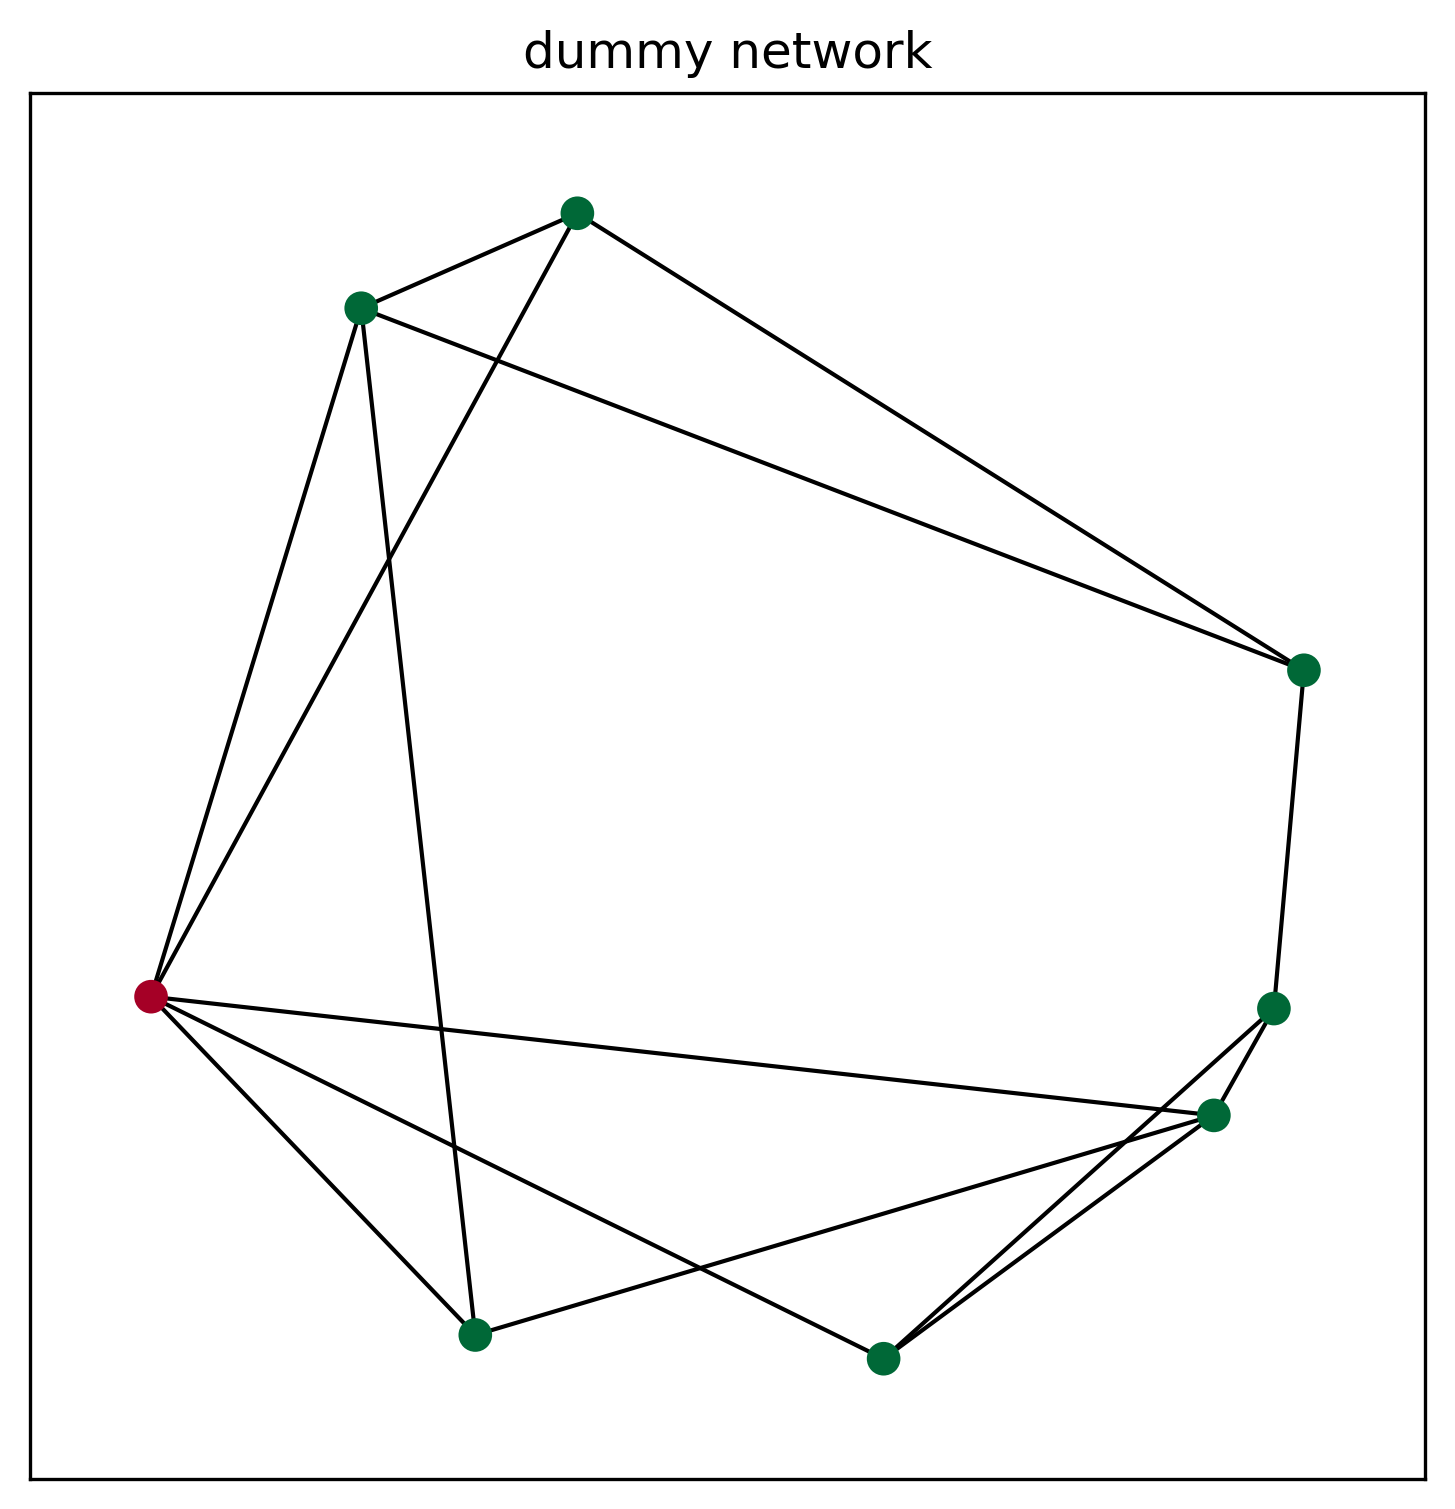

In [ ]:
draw_map("dummy network", network, (6,6), False, True)


In the graph above, note that node 004 is red, indicating it has poor node health compared to the other nodes, which are green.

## print_path

Prints out only the path taken by the algorithm and ignores all other edges and nodes. In-work for later implementation.

In [ ]:
def print_path(path, network, name):
    print_net = dict()
    print_net["nodes"] = path
    print_net["edges"] = []
    for edge in network["edges"]:
        if str(edge[0]) in path and str(edge[1]) in path:
            print_net["edges"].append((edge[0],edge[1]))


    print_net["coordinates"] = [network["coordinates"][network["nodes"].index(x)] for x in path]
    print_net["node_health"] = [network["node_health"][network["nodes"].index(x)] for x in path]

    print(path)
    print(print_net)
    draw_map(name, print_net, (5,5), True)
    return print_net

________________________________________________
# GA Functions

#### Starting parameters for testing

In [ ]:
# time_offsets = np.rand

sim_time = 0


network = { "nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines whic nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.1, 0.6, 0.9, 1.2, 1.8, 2.2, 2.7, 3]} # node offsets, which determines coordinates


# define lists from the dictionary
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
offsets = network["offsets"]

In [ ]:
pop_size = 50 # may increase as desired
number_gen = 100 # start with 100 generations
p_cross = 0.75 # 50/50 chance of crossover
p_mut = 0.05 # 5% chance of mutation


<a id="create_population"></a>
## create_population

Helper function that takes scenario parameters (network size, population size, alphabet) and creates a list of size `len(pop_size)` with characters from the alphabet

- inputs
    - `network_size`: size of the network
    - `pop_size`: int that defines how many individuals to create
    - `alphabet`: the set of acceptable characters (genes) with which to create a chromosome for an individual
- output
    - `init_pop`: the initial population set, with valid characters and correct length

In [ ]:
def create_population(network_size, pop_size, alphabet):

    init_pop = [random.sample(alphabet, network_size) for _ in range(pop_size)]

    assert len(init_pop) == pop_size
    return init_pop

In [ ]:
# test cell

testNetSize = 10 # = len(net)
ALPHABET2 = [x for x in range(testNetSize)]
# print(ALPHABET2)
a_pop = [random.sample(ALPHABET2, testNetSize) for _ in range(5)]
# print('\n'.join(' '.join(map(str, sub)) for sub in a_pop))

testSize = 10
testNetSize = 10
test_pop = [random.sample(ALPHABET2, testNetSize) for _ in range(testSize)]
#print(pop)

sol = create_population(testNetSize, testSize, ALPHABET2)
#print('\n'.join(' '.join(map(str, sub)) for sub in sol))

### getNextNeighbor

Returns the next neighbor; this might be a node in the path, it might be the end node, or it might return None if no node is found (i.e. pendulum node). If there are one or more nodes available that are *not* already in the path, one will be picked and returned as the next node. If there are no nodes available (all are already in the path), None is returned.

Input:
- currentNode: where are we right now
- nodes: nodes of the network
- chromosome: this is the blueprint for how to build a path
- path
- neighborhood: output of getNeighbors function in network_functions section; set object of all neighbors

Output:
- None: if there are no possible next moves, return None
- nextNode: return the next node to add to the path

In [ ]:
def getNextNeighbor(currentNode, nodes, chromosome, path, neighborhood):
    neighbors = list(get_node_neighbors(neighborhood, currentNode)) # --> retrieve set of neighbors fur current node
    keepList = []

    for i, neighbor in enumerate(neighbors):
        if neighbor not in path:
            keepList.append(neighbor)

    # if there are no neighbors after checking for possible next moves, return None
    if len(keepList) == 0:
        return None

    # if there are possible moves, pick the one with highest priority (per the chromosome)
    else:
        neighbor_scores = [chromosome[list(nodes).index(n)] for n in keepList]

        # find the highest priority next move; ties broken by whichever one is first in the list of neighbors
        nextNode = keepList[neighbor_scores.index(max(neighbor_scores))]

    return nextNode

In [ ]:
testNet = { "nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines whic nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.1, 0.6, 0.9, 1.2, 1.8, 2.2, 2.7, 3]} # node offsets, which determines coordinatestestCurrentNode = "003"
testStartNode = "001"
testEndNode = "005"
testCurrentNode = '002'
testChromosome = [8, 3, 0, 5, 2, 1, 6, 7]
testPath = [ '001', testCurrentNode]
testNeighbors = ["001","002","004"]
testNeighborhood = get_neighbors(testNet["nodes"], testNet["edges"])


In [ ]:
res = getNextNeighbor(testCurrentNode, testNet["nodes"], testChromosome, testPath, testNeighborhood)
#print(res)

<a id="create_path"></a>
### create_path

This function takes a chromosome and determines the path that it defines from a given starting node to a given ending node. Uses the getNextNeighbor function, above.

Input:
- startNode: the node at which to start, assuming it is a valid point (can't start on a point with 0 health, or that isn't in the network)
- endNode: node at which to end, assuming valid point (as for startNode)
- network: the planar map with nodes, edges, coordinates, node health, offsets
- chromosome: the chromosome of an individual in the population

Output:
- path: the path determined by the chromosome, given the start and end nodes


In [ ]:
def create_path(startNode, endNode, nodes, chromosome, neighborhood):
    path = [] # create empty path
    currentNode = startNode #set the currentNode to start (only runs the first time)
    complete = False #set to False, since this only happens the first run
    path.append(currentNode)

    while complete != True:
        nextNeighbor = getNextNeighbor(currentNode, nodes, chromosome, path, neighborhood)

        if nextNeighbor != None:  # if we get something that is *not* None for next neighbor, update current node...
            #print(nextNeighbor, "is the next neighbor to pick")
            currentNode = nextNeighbor
            if currentNode not in path:
                path.append(currentNode) #... and add to the path
                # print("path updated, is now:", path)

            if currentNode == endNode: #if we found the end node, return the path
                complete = True
                # print("found endNode")
                return path #exit the function here if we found the end node

        elif nextNeighbor == None: # if we *did* get None for a nextNeighbor, we're out of moves; return complete
            complete = True
            return path

    # print("path is ", path)
    return(path)


In [ ]:
#testNet = {"nodes": ["001","002","003","004","005","006","007","008"]}
testStartNode = "001"
testEndNode = "005"
testChromosome = [8, 3, 4, 5, 2, 1, 6, 7]
testPath = []
testNeighbors = ["001","002","004"]
testNeighborhood = {'001': {'002', '003'},
                    '002': {'001', '003', '004'},
                    '003': {'001', '002', '004', '005'},
                    '004': {'002', '003', '005', '006', '007'},
                    '005': {'003', '004', '007'},
                    '006': {'004', '007', '008'},
                    '007': {'004', '005', '006', '008'},
                    '008': {'006', '007'}}

for neighbor in testNeighbors:
        if neighbor in testPath: testNeighbors.remove(neighbor)
print(testNeighbors)


testScore = [testChromosome[testNet["nodes"].index(n)] for n in testNeighbors]
print(testScore)

testNext = getNextNeighbor(testStartNode, testNet["nodes"], testChromosome, testPath, testNeighborhood)
print(testNext)

['001', '002', '004']
[8, 3, 5]
003


In [ ]:
pathT = create_path(testStartNode, testEndNode, testNet["nodes"], testChromosome, testNeighborhood)
print(pathT)

['001', '003', '004', '007', '008', '006']


### get_path_length

returns total path length between nodes in the path. Take a single input, which is an ordered list of what the nodes are in the path, and computes distance between one node and the next.

Input:
- path_coordinates: list of coordinates for all nodes in a path, in order. If not in order, this will be wrong.

Output:
- total path length from first node in list to last node in list.

In [ ]:
def get_path_length(path_coordinates):
    total_distance = 0
    from math import dist

    for i in range(len(path_coordinates)-1):
        total_distance += dist(path_coordinates[i], path_coordinates[i+1])

    return total_distance


In [ ]:
test_coords = [(1.98,1.2),(.77,1.97),(.41,1.81)]
get_path_length(test_coords)

1.828178841216427

### datarate

Determines the effective datarate through the network.

Inputs:

- path: single path through a network of nodes
- txRate: constant - speed of node's crosslink datarate
- msgSize: size of sample message being sent
- intraNodeDataRate: delay added by each node; fundamentally, this would be something like processing speed or retransmission speed in terms of bytes per second (or GB/s, or MB/s, etc.)
- network: provides node health, node position, edge information for use here
- semimajor_axis: the semimajor axis (earth radius plus orbit altitude) of the satellite orbit; assumes circular orbits

Output:
- pathDatarate: the effective datarate across the provided path

#### Discussion
In a perfect world, the datarate would be more precise and latency sources would be more detailed. The delays accounted for here are related to:
- delay caused by hardware (data moving through hardware)
    - This is accounted for with the *number* of nodes traversed
- delay caused by a noisy RF/EM environment (i.e. jamming) or damaged nodes (i.e. power loss)
    - This is accounted for with the *health* of each node
- delay as a result of signal propagation through the transmission medium (i.e. through vacuum)
    - This is accounted for with the *length* of the path

This is imprecise, but representative for the problem. A more detailed analysis may consider the following, for example:
- Transmission rate over distance: the signal strength at a receiver is determined by the inverse square of distance (power law) from the transmitter
- Retransmission delays caused by high bit error rate (similar to the noisy RF/EM environment): if a signal is too degraded, it may need to be retransmitted
- Hardware-specific delays: propagation of the signal through a node (satellite) is determined by the type of retransmission being performed (bent-pipe or processed and re-transmitted) as well as the specific hardware being used (propagation through each hardware component involved in retransmission)


In [ ]:
def datarate(path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt = None):

    node_time_delay, path_latency, node_latency = 0.0, 0.0, 0.0

    if startNode not in path:
        print("Something fishy is going on: start node isn't in the path.")
        return None

    if endNode not in path:
        # print("The path ",path," doesn't reach the end node: datarate is 0")
        return 0

    else:
        c = 299792 #lightspeed in km/s
        if orbit_alt == None: semimajor_axis = 7000 # 6371 km radius of earth; 629 km orbit altitude (LEO constellation or so)
        else: semimajor_axis = 6371+orbit_alt

        # what is the fixed delay caused by each node (length of time to get through a node * number of nodes)
        node_time_delay = len(path)*msgSize/nodeRate  # number nodes * size of message / processing speed

        # what is the "light" delay between nodes - i.e. what is the total path length?
        path_coordinates = [coordinates[nodes.index(node)] for node in path] # ordered coords
        path_latency = get_path_length(path_coordinates)/c*semimajor_axis # length/time*orbit height*2

        # what is the delay caused by node degradation (i.e. retransmission time, packets resent, etc) - node health
        for node in path:
            node_latency += msgSize/(txRate) * 1/node_health[nodes.index(node)]


        pathDatarate = msgSize/(node_latency + path_latency + node_time_delay)
        return pathDatarate

#### test of code to calculate the effective datarate across a path:

In [ ]:
testNet = {"nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines whic nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.1, 0.6, 0.9, 1.2, 1.8, 2.2, 2.7, 3], #} # node offsets, which determines coordinatestestCurrentNode = "003"
           "node_health": [1,.4,.2,1,.91,.61,.81,.991]}

testStartNode = "001"
testEndNode = "005"
testCurrentNode = '002'
testChromosome = [8, 3, 0, 5, 2, 1, 6, 7]
testPath = [ '001', testCurrentNode]
testNeighbors = ["001","002","004"]
testNeighborhood = get_neighbors(testNet["nodes"], testNet["edges"])
testHealth = testNet["node_health"]
testCoordinates = testNet["coordinates"]
testNodes = testNet["nodes"]


testMaxTx = 100 # MB/s
testMsgSz = 100 # MB
testNodeRate = 100 # MB/s

#print(testNeighborhood)


In [ ]:
path_coordinates = [testNet["coordinates"][nodes.index(node)] for node in ["001","005","008","002"]] # ordered coords
print(path_coordinates)


[(1.98, 1.2), (0.6, 0.08), (1.93, 0.63), (0.77, 1.97)]


From the given start and end node, there is no connection: effective datarate should be 0:

In [ ]:
datarate(pathT, testStartNode, testEndNode, testMaxTx, testMsgSz, testNodeRate, testHealth, testCoordinates, nodes, orbit_alt = None)


0

Above, we see the desired result. Now, looking at the path from the testStartNode to node "006", we should see some calculated datarate:

In [ ]:
datarate(pathT, testStartNode, "006", testMaxTx, testMsgSz, testNodeRate, testHealth, testCoordinates, nodes, orbit_alt = None)


5.876300132903677

<a id="evaluate"></a>
## evaluate

This function uses check_score; it takes a population and checks the score of the individuals against the target value.

inputs:
- `target`: the target state
- `population`: the population of individuals
- `alphabet`: alphabet being used for the problem


outputs:
- a list of length len(population) of scores for each individual in the population

In [ ]:
def evaluate(network, population, startNode, endNode): #, alphabet, --> no?

    #===========================================#
    # Initializations
    nodes, node_health, coordinates = network["nodes"], network["node_health"], network["coordinates"] # add orbit alt.?
    txRate, msgSize, nodeRate = 100, 100, 100 # MB/s, MB, and MB/s for nice numbers
    scores = []
    #===========================================#

    neighborhood = get_neighbors(network["nodes"], network["edges"])

    for chromosome in population:
        path = create_path(startNode, endNode, nodes, chromosome, neighborhood)  # generate path

        # score path
        score = datarate(path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt = None)

        # add score to scores
        scores.append(score)

    return scores


In [ ]:
evaluate(testNet, test_pop, "002","004")

[8.667396360060064,
 6.357000593695155,
 0,
 18.066857023702386,
 4.408686163687834,
 18.066857023702386,
 0,
 4.849924837952204,
 4.408686163687834,
 18.066857023702386]

<a id="mutate"></a>
## mutate

Creates a mutation in the string based on the characters we're using, the probability of mutation, and a given string.

Inputs:
- individual: the chromosome of an individual (prioritization)
- alphabet: set of possible prioritization values (i.e. 1 through #nodes)
- p_mut: mutation rate; rate at which mutations likely to happen
- method: method of mutation picking; default is checking every pair and seeing whether to mutate. Otherwise, just flip two nodes.

Outputs:
- mutated (or not mutated) individual

In [ ]:
def mutate(individual, p_mut, method = 'default'):
    random.seed(13)

    if method != 'default':     # method 1: switch two random elements
        if rand() < p_mut:
            mutants = random.sample(range(0, len(individual)), 2) # find two random points
            temp1, temp2 = individual[mutants[0]], individual[mutants[1]] # save them
            individual[mutants[0]], individual[mutants[1]] = temp2, temp1 # swap them

    else: # method 2: check each pair and randomly switch them
        for i in range(len(individual)-1):
            if rand() < p_mut:
                temp1, temp2 = individual[i], individual[i+1] # save values for current and next elements
                individual[i], individual[i+1] = temp2, temp1 # swap the two values and move along

    return individual

In [ ]:
# test cell
#ALPHABET2
test_indiv = [1, 5, 2, 4, 9, 3, 8, 7, 6]
test_mut_rate = 0.5 #setting it high so it does it all the time
print(mutate(test_indiv, test_mut_rate))

[1, 5, 4, 9, 3, 8, 2, 7, 6]


### genePairing

This does the zipping up of genes. A random set of numbers that is half the length of the chromosome is generated. This determines the references for which genes to directly move to the offspring, and these elements of the offspring are filled in from one parent. Next, the function scans (using the iterator j) through the second parent to add the next available un-used gene to the offspring with vacuum filling. The result is a single offspring that has a 50/50 genetic split between parents. This also introduces some randomness, as the iterative infilling of genes from the second parent happens potentially out of order compared to the parent's chromosome.

Note: this should be run twice to get full genetic replacement: the fitter of p1 and child1 will be kept for the next generation; ditto with p2 and child2. This function is used by the `crossover` function.

Inputs:
- p1: chromosome for parent 1
- p2: chromosome for parent 2
- pattern: set of genes (references) to transfer directly from p1 to child

Output:
- child: new "child" chromosome

In [ ]:
def genePairing(p1, p2, pattern):
    assert len(p1) == len(p2)

    child = [None]*len(p1) #assumes p1 and p2 are same length
    for i in pattern:
        child[i] = p1[i]

    j = 0
    for i, item in enumerate(child):
        if item is None:
            match = False
            while match == False and j < len(p2):
                if p2[j] not in child:
                    child[i] = p2[j]
                    match = True
                else: j+=1

    return child

<a id="crossover"></a>

## crossover

Performs crossover between two individuals. In this implementation, I will generate one number to be the fulcrum and split the strings there, then perform crossover.

- inputs
    - indiv1: parent 1
    - indiv2: parent 2
    - cross_rate: some rate at which crossover will happen from 0-1


- outputs
    - child1: child 1 (may be parent 1 if no crossover)
    - child2: child 2 (may be parent 2 if no crossover)


In [ ]:
def crossover(indiv1, indiv2, p_cross):
    random.seed(13)
    if rand() < p_cross:
        child1, child2 = [None]*len(indiv1),[None]*len(indiv2)

        # half (rounded) number of positions as len/chromosome
        pattern = random.sample(range(0, len(indiv1)), len(indiv1)//2)
        child1 = genePairing(indiv1, indiv2, pattern)
        child2 = genePairing(indiv2, indiv1, pattern)

    else:
        child1, child2 = indiv1, indiv2

    return [child1, child2]


In [ ]:
p1 = random.sample(range(10), 10)
p2 = random.sample(range(10), 10)
alist = [1, 2, 4, 5, 9]

crossover(p1, p2, .9)



[[4, 9, 2, 5, 1, 6, 8, 7, 0, 3], [1, 8, 3, 5, 2, 0, 7, 4, 6, 9]]

<a id="reproduce"></a>

### reproduce

This is the function that applies crossover and mutation to the parents provided inside the genetic algorithm.

Inputs:
- parent1: first parent, in this setting it's going to be for lists of chars
- parent2: the second parent
- node_health: health of nodes
- coordinates: coordinates of nodes
- neighborhood: neighbors for each node in network
- scenario constants:
   - p_mut: mutation rate
   - p_cross: crossover rate
   - startNode: node to start at
   - endNode: node to end at
   - txRatge: transmission datarate
   - msgSize: size of transmitted message
   - nodeRate: datarate through a network node
   - orbit_alt: default is None, which causes it to use a 7000km semimajor axis circular orbit (670km orbit)

   

Outputs:
- child1: first child, which is either one offspring or the first parent depending on which had a better score
- child2: second child, as above



In [ ]:
def reproduce(parent1, parent2, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, node_health, coordinates, neighborhood, orbit_alt = None):

    # create next generation; if alternate mutation type is desired add any third param to mutate()
    children = crossover(parent1, parent2, p_cross)
    child1, child2 = mutate(children[0], p_mut, 'alt'), mutate(children[1], p_mut, 'alt')


    # Find paths for each individual
    child1_path = create_path(startNode, endNode, nodes, child1, neighborhood)
    child2_path = create_path(startNode, endNode, nodes, child2, neighborhood)
    parent1_path = create_path(startNode, endNode, nodes, parent1, neighborhood)
    parent2_path = create_path(startNode, endNode, nodes, parent2, neighborhood)

    # get the scores (datarates) for each individual based on their path through the network
    ch1 = datarate(child1_path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt)
    ch2 = datarate(child2_path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt)
    p1 = datarate(parent1_path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt)
    p2 = datarate(parent2_path, startNode, endNode, txRate, msgSize, nodeRate, node_health, coordinates, nodes, orbit_alt)

    # pick the individuals in the next generation; keep parents if offspring are less fit
    indivs = [child1, child2, parent1, parent2]
    scores = [ch1, ch2, p1, p2]
    result_list = [i for _,i in sorted(zip(scores,indivs), reverse = True)]

    return result_list[0], result_list[1] #return two individuals with highest scores





In [ ]:
# test cell
random.seed(13)
p1 = random.sample(range(8), 8)
p2 = random.sample(range(8), 8)
test_mute = 0.5
test_cross = 0.5
testStart = "002"
testEnd = "008"
testTxRate = 100
testMsgSize = 100
testNodeRate = 100


testNetwork = { "nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
               "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines whic nodes are connected
               "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
               "offsets": [0.1, 0.6, 0.9, 1.2, 1.8, 2.2, 2.7, 3],  # node offsets, which determines coordinates
               "node_health": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

testHood = get_neighbors(testNetwork["nodes"], testNetwork["edges"])

# define lists from the dictionary
testNodes = testNetwork["nodes"]
testEdges = testNetwork["edges"]
testCoords = testNetwork["coordinates"]
testHealth = testNetwork["node_health"]



In [ ]:
reproduce(p1, p2, test_mute, test_cross, testStart, testEnd, testNodes, testTxRate, testMsgSize, testNodeRate, testHealth, testCoords, testHood)


([2, 1, 0, 4, 6, 7, 3, 5], [1, 2, 7, 0, 5, 6, 4, 3])

<a id="multi-append"></a>

#### multi_append

This is a helper function that lets allows operator to append multiple things to a list in the order they're found in the list. It's just a loop with append, but improves readability when called in higher level functions

Input:
- appendees: list of lists to append, expectation is that they're ordered
- input_list: the list we are appending *to* - i.e. the next generation population

Output:
- updated list with all items from appendees appended to it

In [ ]:
def multi_append(appendees, input_list):

    for item in appendees:
        input_list.append(item)
    return input_list

In [ ]:
test_indiv1 = [2, 1, 0, 8, 9, 4, 7, 5, 3, 6]
test_indiv2 = [5, 1, 0, 2, 8, 7, 9, 3, 4, 6]

test_append = [test_indiv1, test_indiv2]
listTest = []

listTest = multi_append(test_append, listTest)
#print(listTest)

<a id="create_children"></a>
### create_children
This is another helper function that calls the `reproduce` and `multi_append` functions. It shortens the code in the main function slightly, and simplifies the selection process.

Input:
- next_generation: a list of the individuals in the next generation
- population: the current population containing parents
- n: a reference used to pick parents so we don't get overlap; assume it is in the range of 0, pop_size/2
- p_mut: predefined probability of mutation
- p_cross: rate at which crossover happens

Output:
- updated next_generation list

In [ ]:
def create_children(population, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, node_health, coordinates, neighborhood, orbit_alt = None):

    next_gen = []
    pop_size = len(population)
    for i in range(0,pop_size//2):

        parent1, parent2 = population[2*i], population[2*i+1]
        child1, child2 = reproduce(parent1, parent2, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, node_health, coordinates, neighborhood, orbit_alt)
        next_gen.append(child1)
        next_gen.append(child2)
        #next_generation = multi_append([child1,child2], next_generation)

    return next_gen



In [ ]:
#this function is superseded by the version above
def create_children2(next_generation, population, n, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, node_health, coordinates, neighborhood, orbit_alt = None):

    parent1, parent2 = population[2*n], population[2*n+1]
    child1, child2 = reproduce(parent1, parent2, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, node_health, coordinates, neighborhood, orbit_alt)
    next_generation = multi_append([child1,child2], next_generation)

    return next_generation


In [ ]:
# test cell
nextGenTest = []

testPop = [[5, 1, 0, 2, 8, 7, 9, 3, 4, 6],[6, 8, 1, 0, 4, 2, 7, 3, 9, 5],[2, 1, 0, 8, 9, 4, 7, 5, 3, 6], [5, 1, 0, 2, 8, 7, 9, 3, 4, 6]]

nTest = 0
test_cross_rate = 0.99

p_mut_test = 0.99

test_mute = 0.5
test_cross = 0.5
testStart = "002"
testEnd = "008"
testTxRate = 100
testMsgSize = 100
testNodeRate = 100

In [ ]:
TestKids = create_children(testPop, test_mute, test_cross, testStart, testEnd, testNodes, testTxRate, testMsgSize, testNodeRate, testHealth, testCoords, testHood)
print(TestKids)

[[6, 8, 1, 0, 4, 2, 7, 3, 9, 5], [4, 1, 0, 2, 8, 7, 3, 9, 5, 6], [2, 1, 0, 8, 9, 4, 7, 5, 3, 6], [2, 1, 0, 8, 9, 4, 7, 5, 3, 6]]


In [ ]:
nextGenTest = []
TestKids2 = create_children2(nextGenTest, testPop, nTest, test_mute, test_cross, testStart, testEnd, testNodes, testTxRate, testMsgSize, testNodeRate, testHealth, testCoords, testHood)
print(TestKids2)

[[6, 8, 1, 0, 4, 2, 7, 3, 9, 5], [4, 1, 0, 2, 8, 7, 3, 9, 5, 6]]


<a id="score_sort"></a>
### score_sort

Sorts the input list of individuals based on their evaluation score from most to least fit. Uses the `evalutate` function defined above to get the scores.

inputs:
- list of individuals
- target
- alphabet

output:
- list of individuals sorted by fitness

In [ ]:
def score_sort(network, population, startNode, endNode):
    score_list = evaluate(network, population, startNode, endNode)
    sorted_list = [(x,y) for y,x in sorted(zip(score_list, population), reverse = True)]

    return sorted_list #, score_list


In [ ]:
# test cell

sort_result = score_sort(testNet, testPop, testStart, testEnd)

print(sort_result, len(sort_result))
print("\n",sort_result[0][0], sort_result[0][1])


[([2, 1, 0, 8, 9, 4, 7, 5, 3, 6], 8.381751653565194), ([6, 8, 1, 0, 4, 2, 7, 3, 9, 5], 5.558395145650681), ([5, 1, 0, 2, 8, 7, 9, 3, 4, 6], 4.839836342793886), ([5, 1, 0, 2, 6, 7, 9, 3, 4, 8], 4.839836342793886)] 4

 [2, 1, 0, 8, 9, 4, 7, 5, 3, 6] 8.381751653565194


<a id="genetic_algorithm"></a>
## genetic_algorithm

This code executes the genetic algorithm to produce some desired result. We have a number of configuration parameters like population size, and we output the most fit in.

Inputs:
- genCount: number of generations to run before quitting
- network: the network to run the GA on
- pop_size: population size for each generation
- p_mut: mutation rate
- p_cross: crossover rate
- startNode: starting node
- endNode: ending node
- epsilon_lim: limit to the number of times (generations) the best score can *not* change before the algorithm exits early to shortcut execution
- (other constants listed earlier)

Outputs:
- best[0]: best is a list of lists that always has one list based on how my score_sort function works (could be better, ah well); the returned item is the 0th list in the best list, i.e. the best individual.
- score_return: all scores from all generations for use in statistical analysis


In [ ]:
def genetic_algorithm(genCount, network, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate, orbit_alt = None):
    assert pop_size % 2 == 0 # if the pop size isn't even, then functions will break later on

    # create initial population, initialize best solution, set current gen, set epsilon count (number of times epsilon < delta)
    nodes, edges, coordinates, health = network["nodes"], network["edges"], network["coordinates"], network["node_health"]
    alphabet = [x for x in range(len(nodes))] # chromosome gene options
    score_return = []

    population = create_population(len(network["nodes"]), pop_size, alphabet) # create initial random population
    best, gen, epsilon_count = None, 0, 0 # initialize stuff to None/zero; below, pull out vars from network
    neighborhood = get_neighbors(nodes,edges) # determine what the neighborhood is this time around

    while gen < genCount and epsilon_count < epsilon_lim: #until we hit generation limit, or answer isn't changing:

        next_generation = [] # empty/set up the next generation

        #for i in range(0, pop_size//2): #int(pop_size/2)):  # populate the next generation based on the current generation
        #    next_generation = create_children(next_generation, population, i, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, health, coordinates, neighborhood, orbit_alt)
        next_generation = create_children(population, p_mut, p_cross, startNode, endNode, nodes, txRate, msgSize, nodeRate, health, coordinates, neighborhood, orbit_alt)

        # fittest individual is the first in the list from score_sort
        scores = score_sort(network, next_generation, startNode, endNode)
        print("best score is",scores[0])
        new_best = scores[0]
        if best and new_best < best:
            print("new best is worse this time")
        if gen % (1/10*genCount) == 0:
            print("fittest individual is", new_best[0],"with a score of",new_best[1], "in generation",gen)

        if best and abs(best[1]-new_best[1]) <= epsilon: # don't run the first time
            epsilon_count+=1
            if epsilon_count >= epsilon_lim:
                print("no improvement over",epsilon_lim,"generations, returning current best at generation", gen)
                return new_best, score_return
        if best and abs(best[1]-new_best[1]) > epsilon: #if it hasn't converged, reset counter
            epsilon_count = 0

        # throw away least fit half of individuals and replace with randos
        for i in range(len(scores)): #was pop_size
            if i < len(scores)//2: #int(pop_size/2):
                #population[i] = scores[i][0] #add the fittest individuals
                next_generation.append(scores[i][0]) #add the fittest individuals

            else:
                #population[i] = create_population(len(network["nodes"]), 1, alphabet)[0] #add another random individual
                next_generation.append(create_population(len(network["nodes"]), 1, alphabet)[0])
                #print(population[i], "new kid on the block")

        # Randomly shuffle the population in case we start to get concentrations of fit individuals
        population = deepcopy(next_generation)
        random.shuffle(population)
        #print(population)
        best = deepcopy(new_best) #update best

        gen += 1
        score_return.append(scores)

    return best[0], score_return # return the best individual of the entire run and also all scores

In [ ]:
pop_size = 100 # may increase as desired
genCount = 100 # start with max 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5
startNode = "006"
endNode = "002"
txRate = 100 # MB/s maximum data throughput out of a node
msgSize = 100 # MB, size of the message to send
nodeRate = 100 # MB/s through a node (and/or into a node?)


network = { "nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines whic nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.1, 0.6, 0.9, 1.2, 1.8, 2.2, 2.7, 3],  # node offsets, which determines coordinates
           "node_health": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



Test run of the Genetic Algorithm to make sure that it outputs results as desired.

In [ ]:
fittest, score_list = genetic_algorithm(genCount, network, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)


best score is ([7, 6, 4, 5, 3, 2, 1, 0], 16.483029741927993)
fittest individual is [7, 6, 4, 5, 3, 2, 1, 0] with a score of 16.483029741927993 in generation 0
best score is ([7, 6, 5, 3, 0, 4, 2, 1], 16.483029741927993)
best score is ([7, 6, 5, 4, 3, 0, 2, 1], 16.483029741927993)
best score is ([7, 6, 5, 4, 3, 0, 2, 1], 16.483029741927993)
best score is ([7, 6, 5, 4, 3, 0, 2, 1], 16.483029741927993)
best score is ([7, 6, 5, 4, 3, 1, 2, 0], 16.483029741927993)
no improvement over 5 generations, returning current best at generation 5


### print_results

This function prints out useful information about the result the GA generates. This includes:
- Number of generations used before the solution converged or quit
- Number of nodes in simulation
- Number of edges in simulation
- start and end nodes used
- The solution path
- Total length of solution path
- Effective datarate of solution path

In [ ]:
def print_results(fittest, scores, network, startNode, endNode, pop_size, orbit_alt = None):
    number_gens, number_nodes, number_edges = len(scores), len(network["nodes"]), len(network["edges"])

    nodes, coordinates = network["nodes"], network["coordinates"]
    # start/end node is just what is input
    neighborhood = get_neighbors(network["nodes"],network["edges"])

    solution_path = create_path(startNode, endNode, network["nodes"], fittest[0], neighborhood)
    print(solution_path)

    #try: path_coordinates = [network["coordinates"][network["nodes"].index(network["nodes"][node])] for node in fittest[0]]
    #except: path_coordinates = [network["coordinates"][network["nodes"].index(network["nodes"][node])] for node in fittest]

    path_coordinates = [coordinates[nodes.index(node)] for node in solution_path] # ordered coords

    path_length = get_path_length(path_coordinates)
    print(path_coordinates, path_length)

    path_datarate = fittest[1]
    if orbit_alt == None:
        semimajor_axis = 7000
    else:
        semimajor_axis = 6371 + orbit_alt

    maximum = []
    minimum = []
    mean = []

    for gen in scores: #for each generation:
        score_list = []
        score_list = [indiv[1] for indiv in gen]
        maximum.append(max(score_list))
        minimum.append(min(score_list))
        mean.append(sum(score_list)/len(score_list))

    results = dict()
    results["numGen"] = number_gens
    results["pop"] = pop_size
    results["numNodes"] = number_nodes
    results["numEdges"] = number_edges
    results["startNode"] = startNode
    results["endNode"] = endNode
    results["chromosome"] = fittest[0]
    results["path"] = solution_path
    results["pathLen"] = path_length
    results["semimajor_axis"] = semimajor_axis
    results["datarate"] = fittest[1]
    results["max"] = maximum
    results["avg"] = mean
    results["min"] = minimum



    #print("{0:0.2f}".format(round(x, 2))
    print(number_gens,": number of generations used to find a solution")
    print(pop_size,": population size")
    print(number_nodes,": number of simulated satellite nodes")
    print(number_edges, ": number of simulated instersatellite links in the network")
    print("starting node is ", startNode, "  -  ending node is ", endNode)
    path_string = '-'.join(solution_path)
    print("path is:  <--",path_string,"-->")
    print("path length is",round(path_length, 5),"in units of semimajor axis; ",round(path_length*semimajor_axis, 5),"in km")
    print("path effective datarate is",round(fittest[1],5),"MB per second")

    return results




In [ ]:
results = print_results(fittest, score_list, network, startNode,endNode, pop_size)

['006', '004', '002']
[(1.28, 0.04), (0.06, 0.65), (0.77, 1.97)] 2.862834345551277
5 : number of generations used to find a solution
100 : population size
8 : number of simulated satellite nodes
13 : number of simulated instersatellite links in the network
starting node is  006   -  ending node is  002
path is:  <-- 006-004-002 -->
path length is 2.86283 in units of semimajor axis;  20039.84042 in km
path effective datarate is 16.48303 MB per second


### ga_results_plot

Plots the min, average, and max fitness for the GA results from one generation to the next.

In [ ]:
def GA_results_plot(results):
    from matplotlib import pyplot as plt

    # Arrang the data
    x_Data = range(results["numGen"])
    y_Data = [results["max"], results["avg"], results["min"]]

    #Set out colours
    colors = ["red", "purple", "blue"]

    for i, color in enumerate(colors):
        plt.plot(x_Data, y_Data[i], color)

    plt.legend(labels = ["max", "avg","min"])

    number_gens = results["numGen"]
    number_nodes = results["numNodes"]
    number_pop = results["pop"]
    plt_label = str(number_nodes) + " nodes, " + str(number_gens) + " generations, " + str(number_pop) + " population"
    plt.title(plt_label)

    plt.grid(visible=True, which='major', axis='both')

    plt.show()


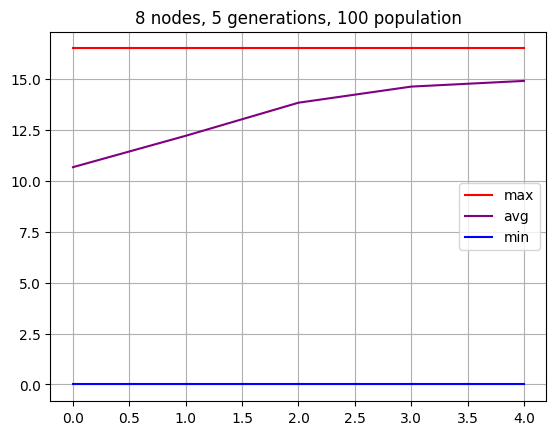

In [ ]:
GA_results_plot(results)

# Problem execution - GA

## Validation case 1: 8-node network

In [ ]:
pop_size = 100 # may increase as desired
genCount = 101 # start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5
startNode = "006"
endNode = "002"
txRate = 100 # MB/s maximum data throughput out of a node
msgSize = 100 # MB, size of the message to send
nodeRate = 100 # MB/s through a node (and/or into a node?)


start_network = { "nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)], # defines which nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.1, 0.6, 0.9, 2, 5, 3, 4, 6],  # node offsets, which determines coordinates
           "node_health": [1, 1, 1, 1, 0.00000001, 1, 0.00000001, 0.00000001]}




In [ ]:
#spot check
c6 = (1.28, 0.04)
c4 = (0.06, 0.65)
c2 = (0.77, 1.97)
dist1 = math.dist(c6, c4)
dist2 = math.dist(c4, c2)
dist_tot = dist1 + dist2
print(dist_tot)

2.862834345551277


In this case, we need to see that the path the algorithm finds follows the following path from the startnode (001) to the endnode(006): `[001, 004, 006]`. The node health for nodes `008`, `005`, and `007` are set to 0, and nodes `002`, `003`, and `008` are left at 100% health to show that the distance travelled has an effect on the optimal solution.

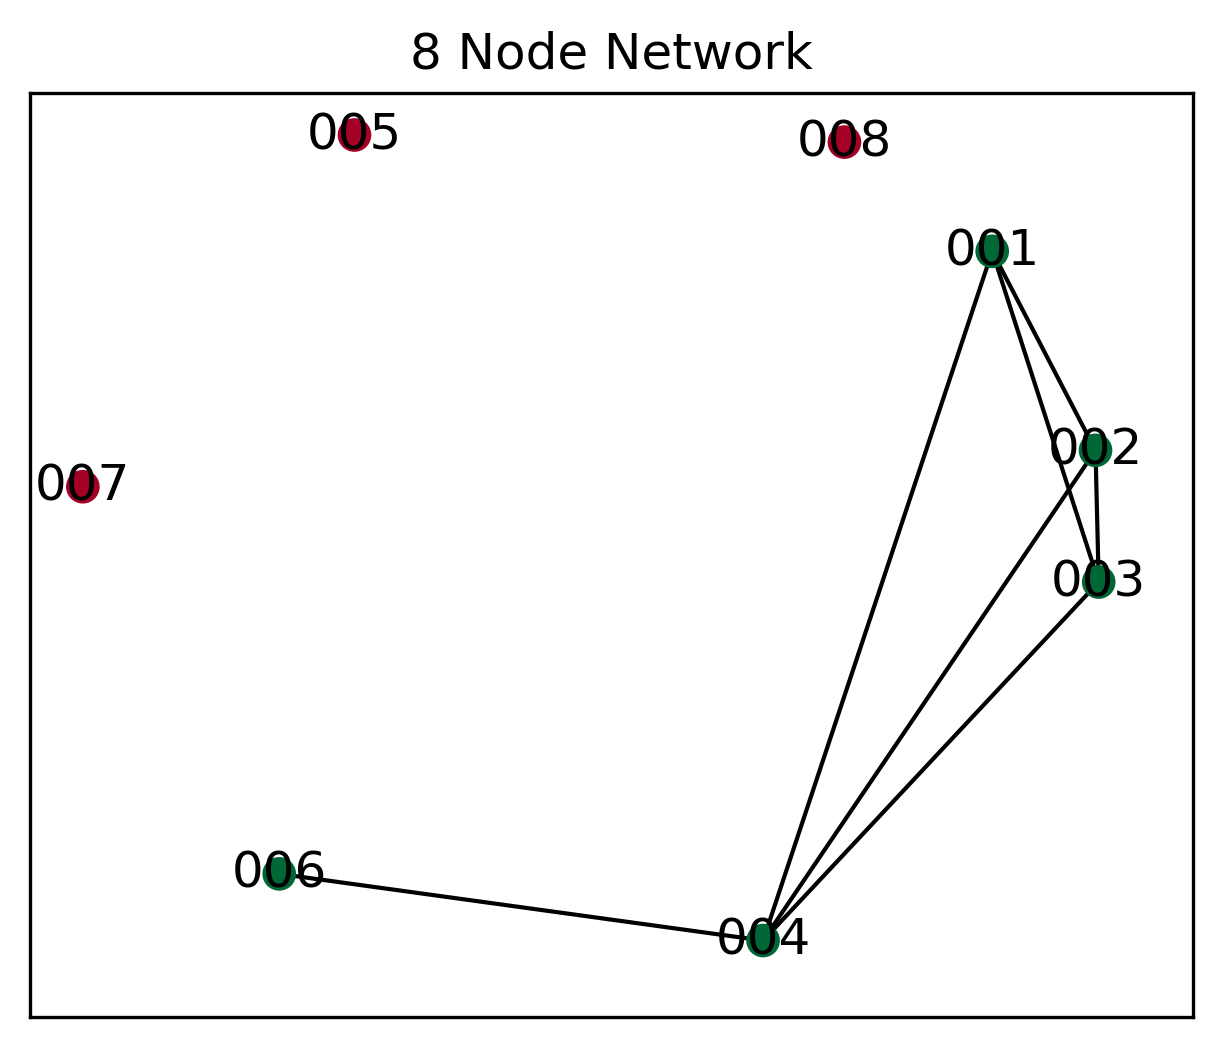

In [ ]:
eight_node_val = update_network(start_network, 0.8, maxRange = 0.85)
#print(network["coordinates"])
draw_map("8 Node Network", eight_node_val, (5,4), True, True)


In [ ]:
fittest, all_scores = genetic_algorithm(genCount, eight_node_val, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)

#create_path(startNode, endNode, network["nodes"], fittest[0], get_neighbors(network["nodes"], network["edges"]))

best score is ([6, 7, 3, 0, 1, 5, 4, 2], 16.594104705158887)
fittest individual is [6, 7, 3, 0, 1, 5, 4, 2] with a score of 16.594104705158887 in generation 0
best score is ([6, 7, 4, 2, 0, 1, 3, 5], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 1, 2], 16.594104705158887)
best score is ([6, 7, 5, 4, 0, 2, 3, 1], 16.594104705158887)
best score is ([6, 7, 5, 4, 1, 2, 0, 3], 16.594104705158887)
best score is ([6, 7, 5, 4, 3, 2, 0, 1], 16.594104705158887)
no improvement over 5 generations, returning current best at generation 5


## Genetic ALgorithm results for Validation case 1



['006', '004', '002']
[(0.19407105452864054, 0.10451614404279158), (0.6674940750779526, 0.028888829665670968), (0.9927248649942301, 0.5849835714501205)] 1.123643225841894
5 : number of generations used to find a solution
100 : population size
8 : number of simulated satellite nodes
7 : number of simulated instersatellite links in the network
starting node is  006   -  ending node is  002
path is:  <-- 006-004-002 -->
path length is 1.12364 in units of semimajor axis;  7865.50258 in km
path effective datarate is 16.5941 MB per second


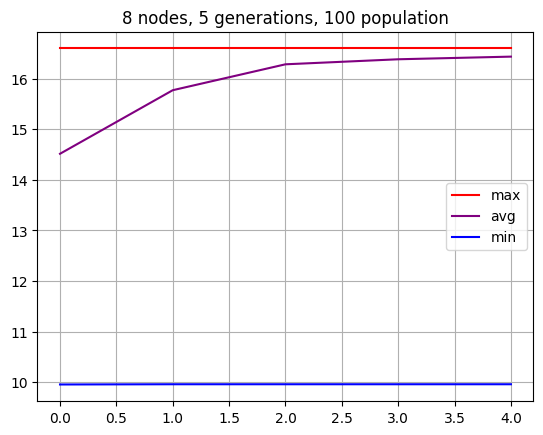

In [ ]:
results = print_results(fittest, all_scores, eight_node_val, startNode,endNode, pop_size)
GA_results_plot(results)


best score is ([6, 7, 0, 5, 4, 3, 2, 1], 16.594104705158887)
fittest individual is [6, 7, 0, 5, 4, 3, 2, 1] with a score of 16.594104705158887 in generation 0
best score is ([6, 7, 0, 5, 4, 3, 2, 1], 16.594104705158887)
best score is ([6, 7, 0, 5, 4, 3, 2, 1], 16.594104705158887)
best score is ([6, 7, 3, 5, 0, 1, 4, 2], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 1, 2], 16.594104705158887)
best score is ([6, 7, 5, 4, 0, 2, 3, 1], 16.594104705158887)
no improvement over 5 generations, returning current best at generation 5
['006', '004', '002']
[(0.19407105452864054, 0.10451614404279158), (0.6674940750779526, 0.028888829665670968), (0.9927248649942301, 0.5849835714501205)] 1.123643225841894
5 : number of generations used to find a solution
20 : population size
8 : number of simulated satellite nodes
7 : number of simulated instersatellite links in the network
starting node is  006   -  ending node is  002
path is:  <-- 006-004-002 -->
path length is 1.12364 in units of semimaj

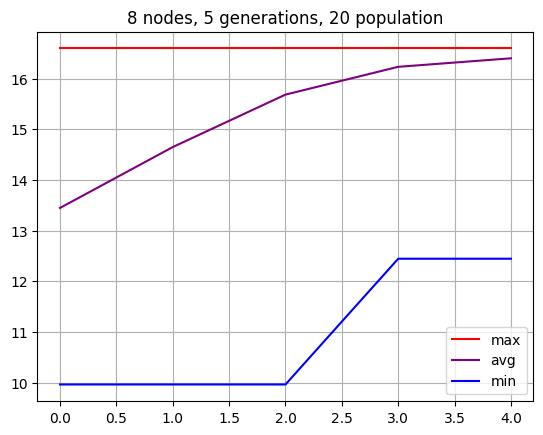

In [ ]:
pop_size = 20
fittest, all_scores = genetic_algorithm(genCount, eight_node_val, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, eight_node_val, startNode,endNode, pop_size)
GA_results_plot(results)

best score is ([6, 7, 0, 5, 4, 3, 2, 1], 16.594104705158887)
fittest individual is [6, 7, 0, 5, 4, 3, 2, 1] with a score of 16.594104705158887 in generation 0
best score is ([6, 7, 0, 5, 4, 3, 2, 1], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 1, 2], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 2, 1], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 2, 1], 16.594104705158887)
best score is ([6, 7, 4, 5, 0, 3, 2, 1], 16.594104705158887)
no improvement over 5 generations, returning current best at generation 5
['006', '004', '002']
[(0.19407105452864054, 0.10451614404279158), (0.6674940750779526, 0.028888829665670968), (0.9927248649942301, 0.5849835714501205)] 1.123643225841894
5 : number of generations used to find a solution
10 : population size
8 : number of simulated satellite nodes
7 : number of simulated instersatellite links in the network
starting node is  006   -  ending node is  002
path is:  <-- 006-004-002 -->
path length is 1.12364 in units of semimaj

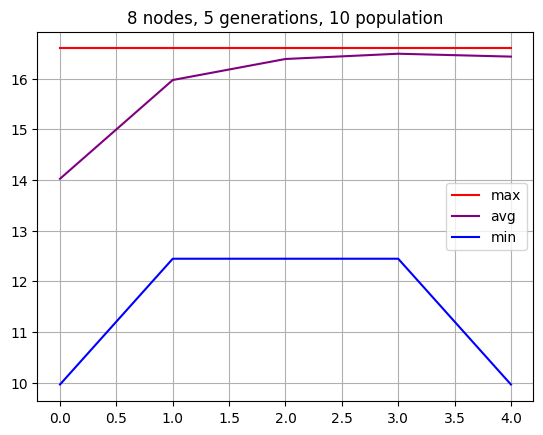

In [ ]:
pop_size = 10
fittest, all_scores = genetic_algorithm(genCount, eight_node_val, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, eight_node_val, startNode,endNode, pop_size)
GA_results_plot(results)

## Validation case 2: 100-node hand-picked scenario

In [ ]:
hundred_node_val = {'nodes': ['0',
  '1',  '2',  '3',  '4',  '5',  '6',  '7',  '8',  '9',  '10',  '11',  '12',
  '13',  '14',  '15',  '16',  '17',  '18',  '19',  '20',  '21',  '22',  '23',  '24',  '25',  '26',  '27',  '28',
  '29',  '30',  '31',  '32',  '33',  '34',  '35',  '36',  '37',  '38',  '39',  '40',  '41',  '42',  '43',  '44',
  '45',  '46',  '47',  '48',  '49',  '50',  '51',  '52',  '53',  '54',  '55',  '56',  '57',  '58',  '59',  '60',
  '61',  '62',  '63',  '64',  '65',  '66',  '67',  '68',  '69',  '70',  '71',  '72',  '73',  '74',  '75',  '76',
  '77',  '78',  '79',  '80',  '81',  '82',  '83',  '84',  '85',  '86',  '87',  '88',  '89',  '90',  '91',  '92',
  '93',  '94',  '95',  '96',  '97',  '98',  '99'],

 'edges': [(0, 43),  (0, 66),  (0, 83),  (0, 88),  (2, 7),  (2, 59),
  (2, 64),  (2, 70),  (2, 87),  (2, 97),  (2, 98),  (7, 42),  (7, 59),  (7, 64),
  (7, 70),  (7, 87),  (7, 97),  (7, 98),  (17, 24), (17, 42),  (17, 43),  (17, 56),
  (17, 66),  (17, 72),  (17, 85),  (24, 42),  (24, 56),  (24, 66),  (24, 70),  (24, 72),
  (24, 85),  (24, 87),  (26, 39),  (26, 52),  (26, 65),  (26, 88),  (39, 52),  (39, 59),
  (39, 64),  (39, 65),  (39, 98),  (42, 56),  (42, 70),  (42, 72),  (42, 85),  (42, 87),
  (42, 97),  (43, 56),  (43, 66),  (43, 72),  (43, 83),  (52, 65),  (52, 83),  (52, 88),
  (56, 66),  (56, 72),  (56, 85),  (59, 64),  (59, 70),  (59, 97),  (59, 98),  (64, 70),
  (64, 97),  (64, 98),  (65, 83),  (65, 88),  (66, 72),  (66, 83),  (66, 85),  (70, 85),
  (70, 87),  (70, 97),  (70, 98),  (72, 85),  (72, 87),  (83, 88),  (85, 87),  (87, 97),  (97, 98)],

 'coordinates': [(0.5331715014690253, 0.9988984380515642),  (0.826641320975728, 0.878557059676915),
  (0.46564709097238793, 0.0011815183442572263),  (0.25994930117264514, 0.0613934998287205),
  (0.9829520651342634, 0.37054999890865103),  (0.9976406216737357, 0.4514839030817822),
  (0.9210251569266725, 0.7696994943170469),  (0.34362246922877693, 0.02508309372070655),
  (0.5310616208674368, 0.9990342430225481),  (0.00924459386510701, 0.4042966492259742),
  (0.19167387858475332, 0.10638216141410645),  (0.6205591856000903, 0.014752142954301162),
  (0.29391458069897525, 0.955553289914057),  (0.9671578723305633, 0.6782232373165216),
  (0.9963061491793119, 0.5606647037972045),  (0.09339481154427076, 0.790984914936979),
  (0.6211934071511924, 0.01491015464855866),  (0.0841318547903393, 0.7775854567513878),
  (0.6520627419917587, 0.9763159901766345),  (0.9217271718608656, 0.2313995671741464),
  (0.6781810604713867, 0.9671739608425238),  (0.42536791249152633, 0.00560132330868085),
  (0.20412952689523373, 0.9030640930978122), (0.4797927021047866, 0.9995914982380847),
  (0.005706230499148979, 0.4246762359368601),  (0.9514592800062577, 0.7149058363475302),
  (0.9990609867538642, 0.530628932404826),  (0.8959356504401838, 0.1946559961117484),
  (0.00029094165670862093, 0.48294546952680845),  (0.0576923483233846, 0.2668392372882653),
  (0.39285985492703945, 0.9883861067984478),  (0.8845977842335482, 0.1804932796283542),
  (0.4588477107696546, 0.9983036113566728),  (0.1642582817166457, 0.12949021793731175),
  (0.04875826110493098, 0.7153622368916016),  (0.04245207217942609, 0.701618188036444),
  (0.9006401687803305, 0.7991445389099863),  (0.986000679931107, 0.3825123874338159),
  (0.9994536718311668, 0.4766327217167869),  (0.9448754029185916, 0.27177669733784693),
  (0.5155564683564465, 0.9997579376981169),  (0.3372486064267326, 0.027229459579005244),
  (0.04920225491280622, 0.2837099331353808),  (0.23825287418579982, 0.9260146031863289),
  (0.2346823326985794, 0.9238001125739972),  (0.995749419201579, 0.4349422305846783),
  (0.8899814295035933, 0.8129129026459821),  (0.7139515158247552, 0.04808767567559136),
  (0.050266358206162765, 0.7184940535549023),  (0.7847763450456349, 0.0890225878439917),
  (0.07790370201987723, 0.7680199903579497),  (0.2541699637404632, 0.9353936072941756),
  (0.9768886865299482, 0.6502570486191607),  (0.3922892544974731, 0.9882605813531232),
  (0.018982387420626357, 0.6364626556550897),  (0.7684777174252548, 0.07819469509485177),
  (0.04411369606497795, 0.7053476999736414),  (0.9944833393848381, 0.5740690695960127),
  (0.9592612744969049, 0.6976842981814148),  (0.7578502838259216, 0.07161555685238558),
  (0.7760568133365985, 0.9168844393959104),  (0.39340718021529353, 0.9885058554105008),
  (0.4223100002256128, 0.006072612689824897),  (0.5685169574392152, 0.9952831781347644),
  (0.755956376166814, 0.07048127689290146),  (0.9798622962018467, 0.6404712663995422),
  (0.1566233785636043, 0.8634453134254536),  (0.4164773430891203, 0.007025390326694914),
  (0.5526588800278794, 0.9972193101179895),  (0.999681560482975, 0.48215796779234266),
  (0.2998256720027963, 0.041818552960873445),  (0.09780413072569255, 0.20295036990650162),
  (0.010420655375159349, 0.6015483398028324),  (0.007125889071062486, 0.4158863223012489),
  (0.22127929155670822, 0.9151081385432831),  (0.07374331562039305, 0.23864729000505058),
  (0.9902064632865951, 0.4015234883231129),  (0.4758698683962809, 0.0005826026770921477),
  (0.03498871491182787, 0.31624879662803107),  (0.18617633883052354, 0.11075109545409684),
  (0.45396779505920787, 0.9978765269705823),  (0.5738143126611533, 0.9945214325450025),
  (0.9882262191764982, 0.6078663937870453),  (0.639922049560149, 0.98002272867739),
  (0.006831503924977778, 0.4176298932919181),  (0.004748839997574861, 0.4312519926379512),
  (0.1640527833908792, 0.8703234635458365),  (0.13147322902664926, 0.162082822165023),
  (0.8658035559203627, 0.8408632548046475),  (0.16041886947015482, 0.13300591859258515),
  (0.020357658056179728, 0.6412204794448999),  (0.03815271712600021, 0.30843516162431156),
  (0.8500831151070879, 0.14301006664484578),  (0.07121603285275807, 0.2428146397683707),
  (0.06320826971893995, 0.7433371824404927),  (0.7932990036722077, 0.09506087563080512),
  (0.9483446877366162, 0.27866983716999577),  (0.45193305415611995, 0.0023157941854679565),
  (0.7269538914334508, 0.054475667148007056),  (0.947031344184253, 0.7239709296244041)],

 'offsets': [3.349577073711627,  3.9950974067350162,  0.21035264097304662,  0.6423629530270994,
  5.115864835651615,  4.95116674024256,  4.284258435447195,  0.4596848784597295,
  3.3453485771449802,  1.5197938333344756,  0.8060756898289426,  6.181259903306976,
  2.8583498858660223,  4.489519858337822,  4.732352558829795,  2.333537865700055,
  6.179952685295719,  2.3009574224470044,  3.592205601919121,  5.4210965671061855,
  3.6475568004484455,  0.2914167229332879,  2.6499685344266264,  3.242759701501971,
  1.561165736920892,  4.4096974435766345,  4.792685392369904,  5.510910771996177,
  1.6782733020669327,  1.2272610579316214,  3.067230361624645,  5.547196629486135,
  3.200787521846429,  0.8778015157508119,  2.1576843594167054,  2.1274397348139926,
  4.212617467088015,  5.091174713479102,  4.90073321958704,  5.327979025813216,
  3.3143032657110205,  0.47313607847190847,  1.2650364194614623,  2.732238405214597,
  2.7238353488520426,  4.984467142253373,  4.1777917750450815,  5.982606566840227,
  2.1646363896648912,  5.818816410775697,  2.278128169899154,  2.769190173670657,
  4.548750013916902,  3.066061872811719,  1.9888214589143018,  5.857953983595185,
  2.135605601788174,  4.7052962603347686,  4.447512524892031,  5.882952826869785,
  3.8680824506447635,  3.0683509056605422,  0.29760476677735576,  3.420651764389807,
  5.887368021164336,  4.569205578994267,  2.5261723717817732,  0.3094247635882274,
  3.3886987399418946,  4.889673275797682,  0.5534899461287993,  1.076243572902479,
  1.9169084619869199,  1.543357861441547,  2.6918845344651965,  1.1623676423729816,
  5.0522307286485635,  0.1898716699103749,  1.3360669083387957,  0.8201200963348555,
  3.190990344630104,  3.431355502457264,  4.636539407211028,  3.566817023483348,
  1.546894360089928,  1.574456007457149,  2.5464216688345513,  0.9702928498355449,
  4.103861699816237,  0.8882133325615751,  1.9987267013815304,  1.3192068388963423,
  5.6491476687380215,  1.1721152883089772,  2.220667789797058,  5.797926164530089,
  5.312544973065951,  0.23787523832631502, 5.953631895851966,  4.389519635452102],

 'node_health': [0.00000001]*100}

hundred_node_val["node_health"][0] = 1
hundred_node_val["node_health"][83] = 1
hundred_node_val["node_health"][88] = 1
hundred_node_val["node_health"][26] = 1
hundred_node_val["node_health"][39] = 1
hundred_node_val["node_health"][64] = 1
hundred_node_val["node_health"][72] = 1
hundred_node_val["node_health"][97] = 1
hundred_node_val["node_health"][98] = 1


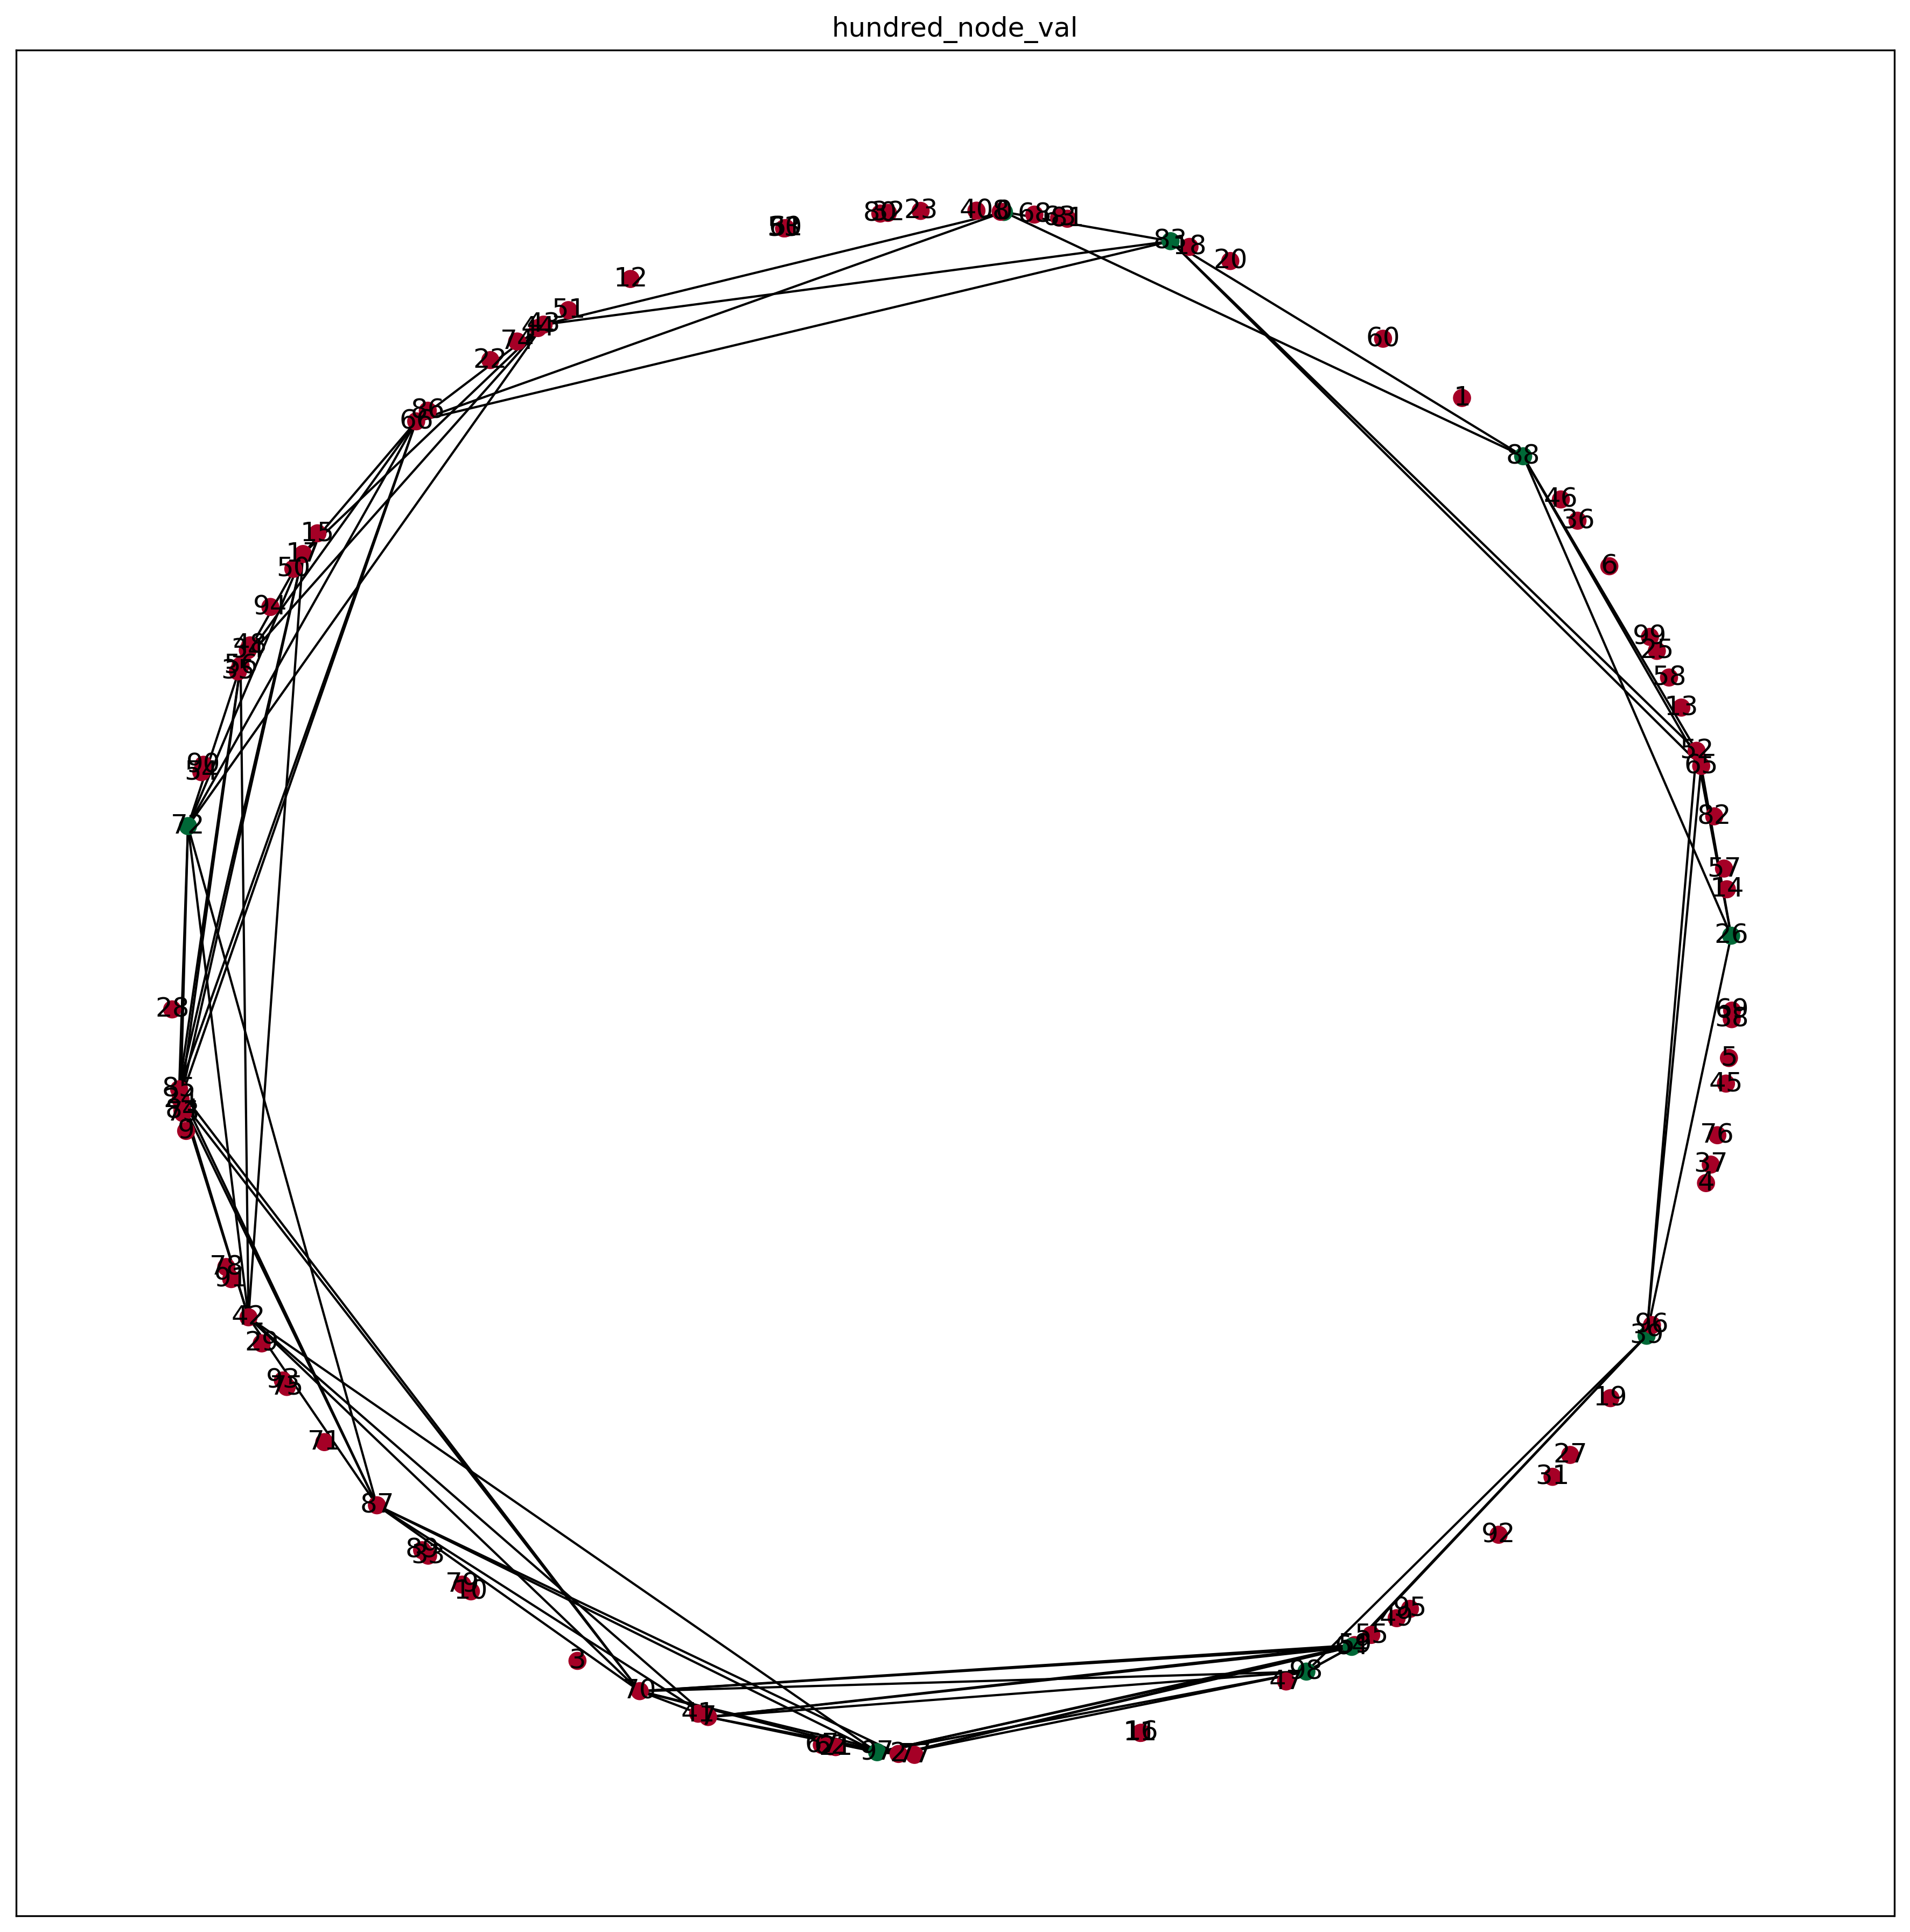

In [ ]:
draw_map("hundred_node_val", hundred_node_val, (15,15), True, True)

#### Run validation case with 100 nodes

best score is ([62, 87, 71, 5, 82, 21, 85, 30, 29, 33, 51, 91, 46, 23, 58, 12, 19, 67, 48, 89, 7, 52, 11, 98, 81, 63, 96, 84, 54, 75, 15, 36, 3, 43, 78, 56, 6, 73, 92, 34, 2, 65, 0, 17, 97, 94, 28, 79, 22, 14, 20, 27, 8, 59, 40, 72, 10, 60, 35, 24, 93, 77, 68, 39, 57, 13, 90, 70, 47, 76, 31, 74, 99, 69, 95, 42, 26, 55, 88, 53, 45, 64, 25, 16, 44, 37, 41, 61, 86, 9, 66, 18, 50, 1, 38, 32, 4, 83, 49, 80], 9.972297114174891)
fittest individual is [62, 87, 71, 5, 82, 21, 85, 30, 29, 33, 51, 91, 46, 23, 58, 12, 19, 67, 48, 89, 7, 52, 11, 98, 81, 63, 96, 84, 54, 75, 15, 36, 3, 43, 78, 56, 6, 73, 92, 34, 2, 65, 0, 17, 97, 94, 28, 79, 22, 14, 20, 27, 8, 59, 40, 72, 10, 60, 35, 24, 93, 77, 68, 39, 57, 13, 90, 70, 47, 76, 31, 74, 99, 69, 95, 42, 26, 55, 88, 53, 45, 64, 25, 16, 44, 37, 41, 61, 86, 9, 66, 18, 50, 1, 38, 32, 4, 83, 49, 80] with a score of 9.972297114174891 in generation 0
best score is ([62, 87, 71, 5, 82, 21, 85, 30, 29, 33, 51, 91, 46, 23, 58, 12, 19, 67, 48, 89, 7, 52, 11, 98, 8

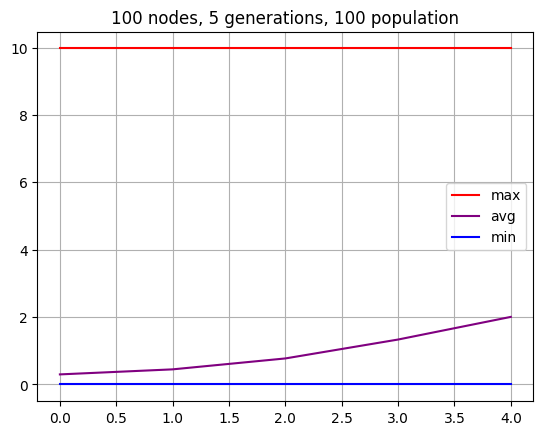

In [ ]:
pop_size = 100 # may increase as desired
genCount = 1000 # start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5

#txRate = 100 # MB/s maximum data throughput out of a node
#msgSize = 100 # MB, size of the message to send
#nodeRate = 100 # MB/s through a node (and/or into a node?)


startNode = '88'
endNode = '97'

fittest, all_scores = genetic_algorithm(genCount, hundred_node_val, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, hundred_node_val, startNode,endNode, pop_size)
GA_results_plot(results)

best score is ([71, 9, 17, 13, 47, 6, 68, 0, 59, 11, 38, 84, 64, 97, 54, 18, 31, 49, 19, 8, 93, 36, 79, 39, 75, 46, 85, 53, 89, 24, 67, 65, 4, 62, 91, 83, 95, 55, 51, 73, 33, 15, 34, 28, 35, 77, 56, 92, 99, 30, 96, 21, 23, 70, 25, 37, 63, 86, 3, 40, 14, 42, 22, 52, 60, 5, 32, 66, 78, 43, 7, 26, 61, 88, 81, 90, 72, 2, 57, 50, 12, 20, 1, 16, 82, 80, 45, 87, 29, 74, 94, 76, 44, 98, 41, 58, 69, 48, 27, 10], 9.972297114174891)
fittest individual is [71, 9, 17, 13, 47, 6, 68, 0, 59, 11, 38, 84, 64, 97, 54, 18, 31, 49, 19, 8, 93, 36, 79, 39, 75, 46, 85, 53, 89, 24, 67, 65, 4, 62, 91, 83, 95, 55, 51, 73, 33, 15, 34, 28, 35, 77, 56, 92, 99, 30, 96, 21, 23, 70, 25, 37, 63, 86, 3, 40, 14, 42, 22, 52, 60, 5, 32, 66, 78, 43, 7, 26, 61, 88, 81, 90, 72, 2, 57, 50, 12, 20, 1, 16, 82, 80, 45, 87, 29, 74, 94, 76, 44, 98, 41, 58, 69, 48, 27, 10] with a score of 9.972297114174891 in generation 0
best score is ([71, 9, 17, 13, 47, 6, 68, 0, 59, 11, 38, 84, 64, 97, 54, 18, 31, 49, 19, 8, 93, 36, 79, 39, 75,

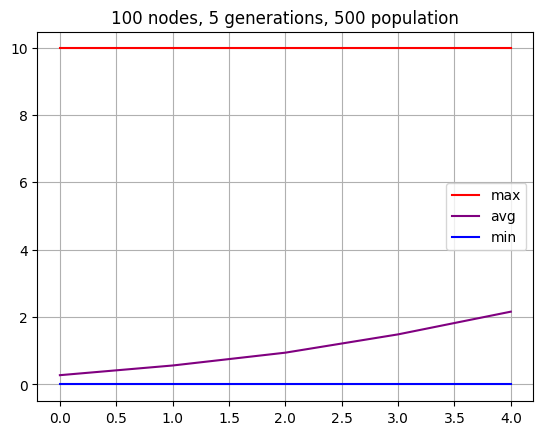

In [ ]:
pop_size = 500 # may increase as desired
genCount = 1000 # start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5

#txRate = 100 # MB/s maximum data throughput out of a node
#msgSize = 100 # MB, size of the message to send
#nodeRate = 100 # MB/s through a node (and/or into a node?)


startNode = '88'
endNode = '97'

fittest, all_scores = genetic_algorithm(genCount, hundred_node_val, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, hundred_node_val, startNode,endNode, pop_size)
GA_results_plot(results)

# Create test datasets

In this section, random test datasets are generated for data collection. Test datasets are created for 1000-node and 100-node networks.

In [ ]:
# included so that a dummy network with the correct format can be used for dataset generation.
network = {"nodes": ["001", "002", "003", "004", "005", "006", "007", "008", "009","010"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7),(7,0),(6,8),(7,8),(8,0),(8,9),(7,9)],
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63), (.96,.70),(.70)],
           "offsets": [0.2, 0.9, 1.8, 2.2, 3.5, 4.3, 5.0, 5.7, 5.9, 6.2],
           "node_health": [1, 1, 1, 0, 1, 1, 1, 1, 0, 0]}

### 1000-Node test network

This network generates 40% live nodes an 60% "dead" nodes (1e-8 health). This causes the network to have fewer edges in it, which decreases the compuation time required to identify all edges between nodes. This is a computational limit on the system.

In [ ]:
random.seed(13)

test1000 = deepcopy(network)
networkSize = 1000
p_health1k = 0.4 # forces chance for health of satellite to be non-zero to be low; useful for managing constellation edges and increasing computation speed.

nodes_1000 = [str(i) for i in range(networkSize)]
offsets_1000 = [rand()*2*math.pi for i in range(networkSize)]
health_1000 = [rand() if rand()< p_health1k else 1e-8 for i in range(networkSize)]

test1000["nodes"] = nodes_1000
test1000["offsets"] = offsets_1000
test1000["node_health"] = health_1000


In [ ]:
t1 = time.time()
test1000 = update_network(test1000, 2, 0.25)
t2 = time.time()

print("Elapsed time is",t2-t1)

Elapsed time is 83.85069870948792


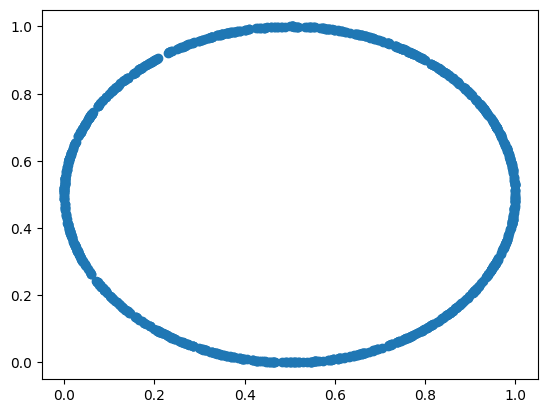

In [ ]:
plt.scatter(*zip(*test1000["coordinates"]))

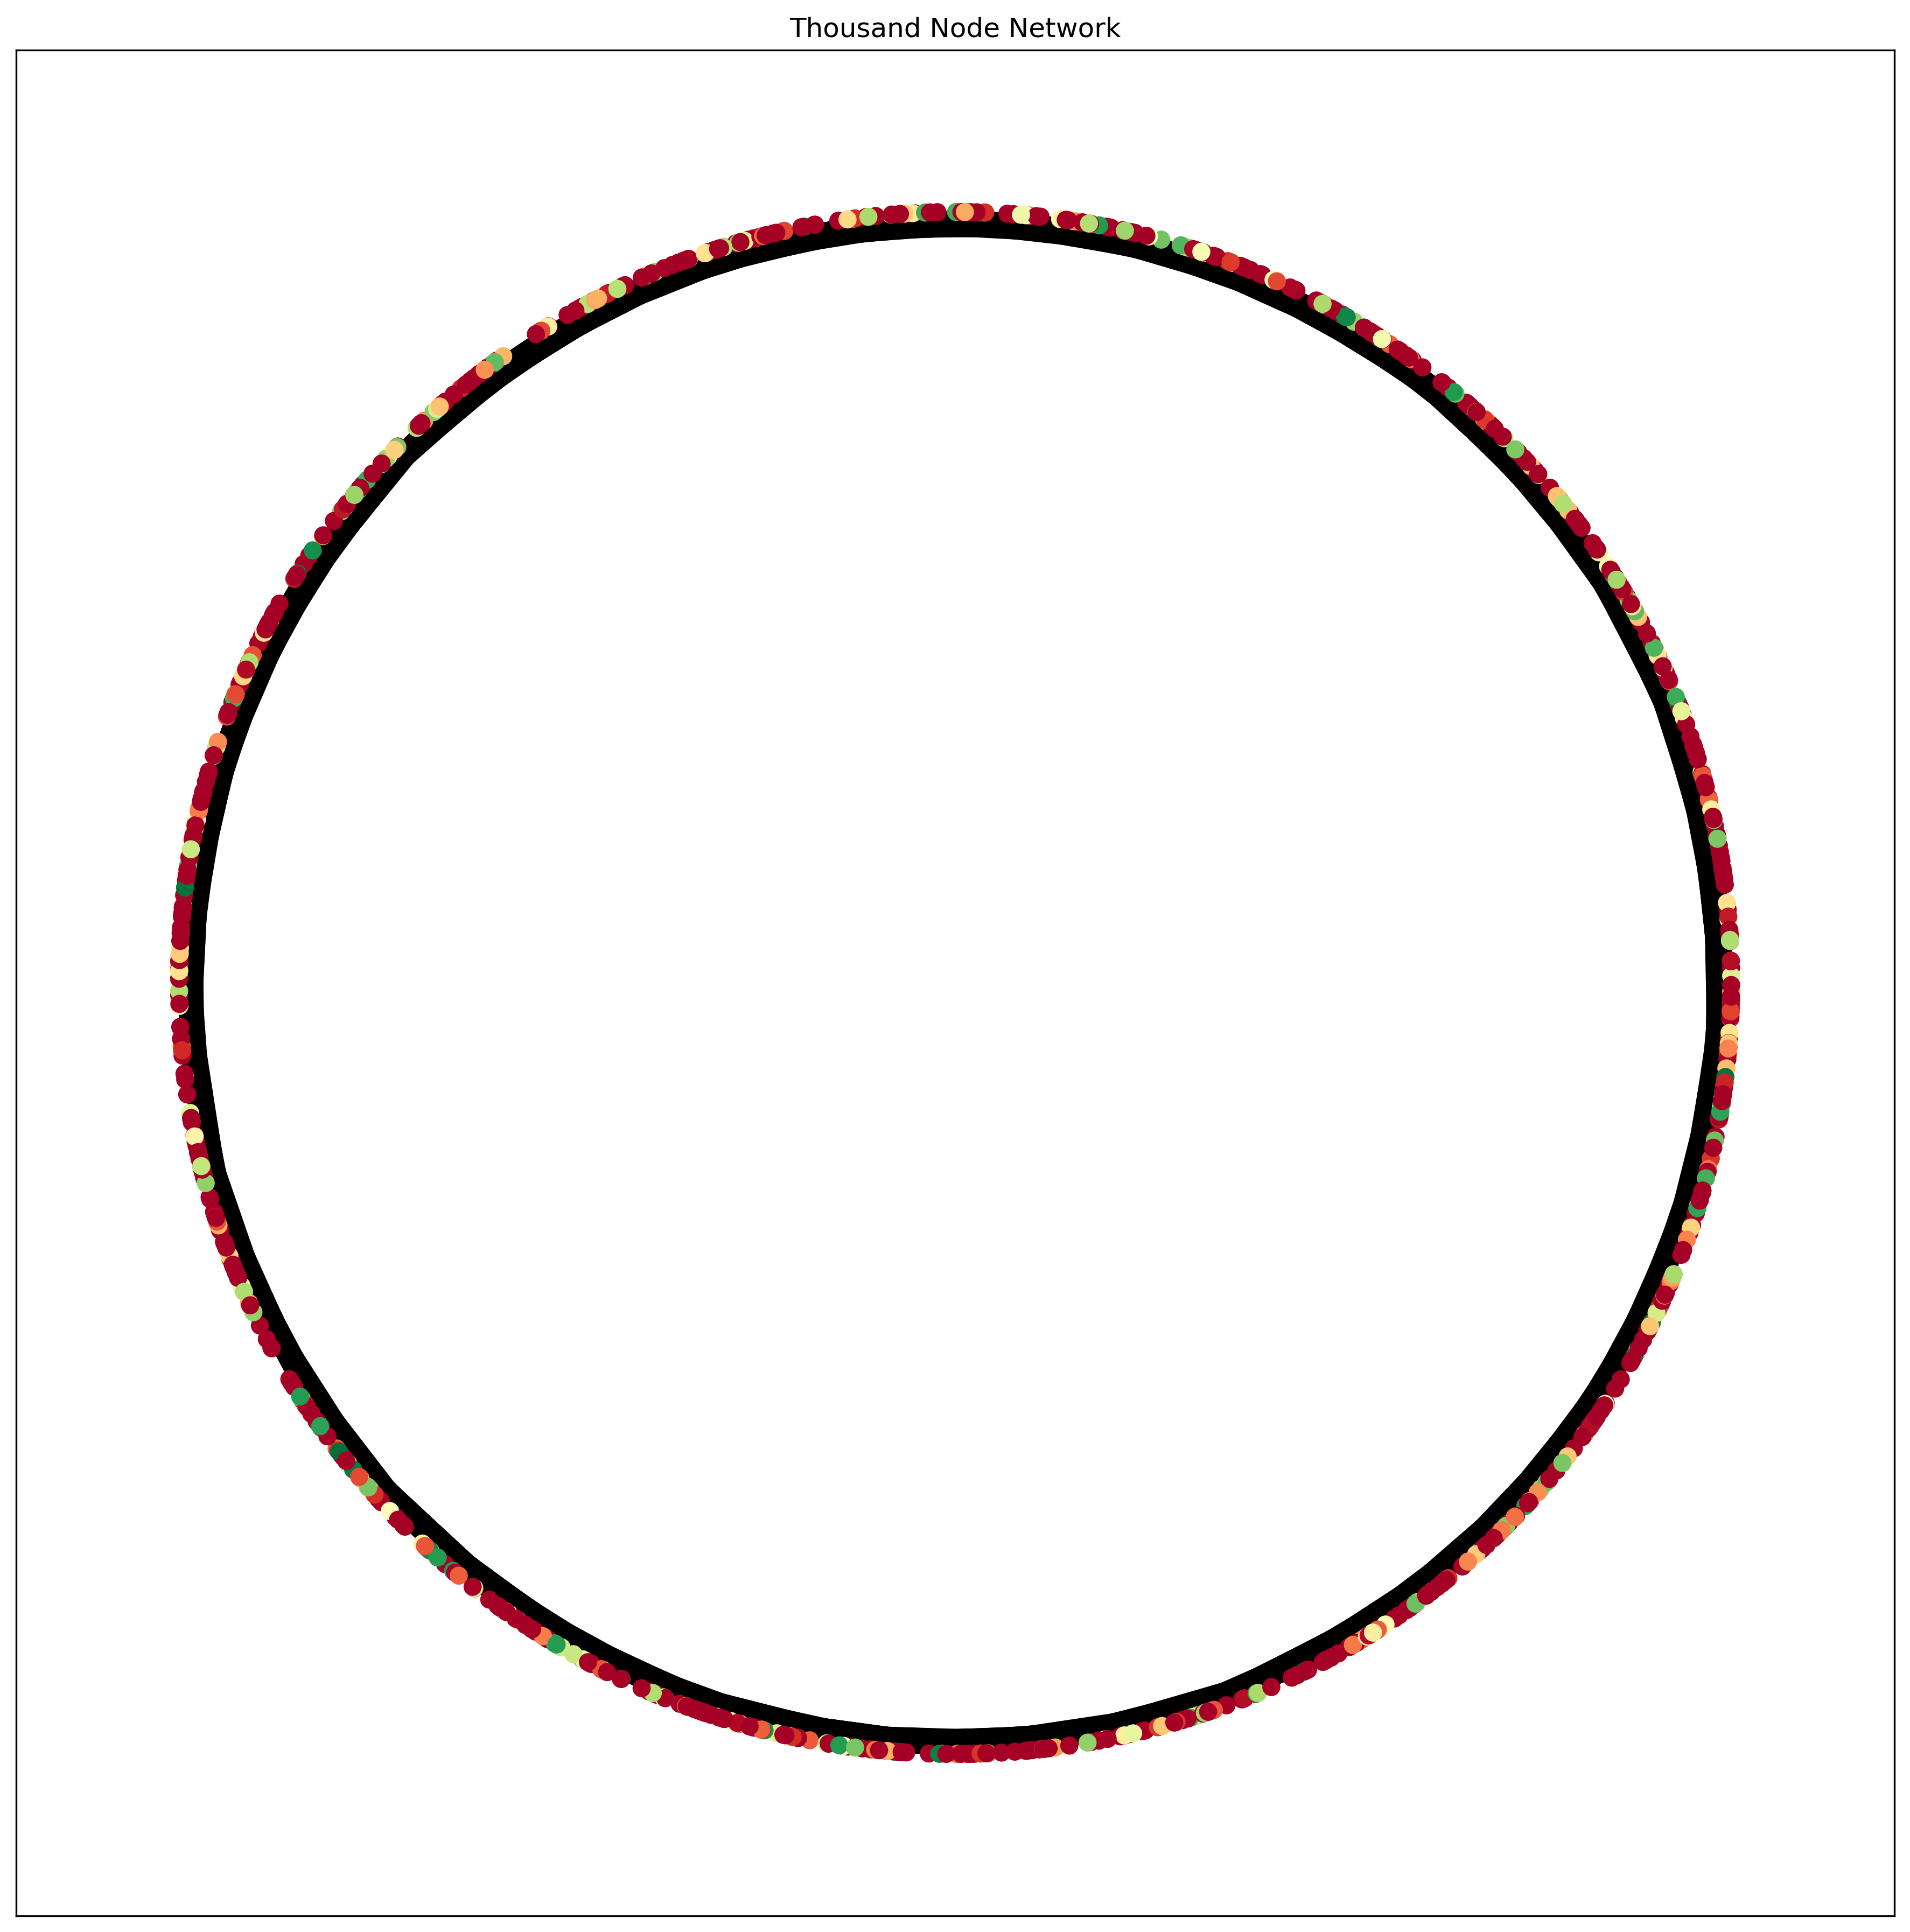

In [ ]:
draw_map("Thousand Node Network", test1000, (15,15), False, True)

Running with the standard google colab CPU, this results in a run-time of about 60-80 seconds to check the entire network and create edges.

Implementation-wise, this would be a limitation for applications: real satellites would likely perform this network check (or one like it) when determining the network topography prior to generating a network traversal solution. As a result **this is an important area for future optimization**. Parallelization and further optimization methods should be used, as should methods to raise the value at which nodes are determined to be "dead." Right now it is set to a small value (0.01 Megabytes per second, or 10 kilobytes per second); in reality this may need to be higher, but the value will depend on what kind of datarate is acceptable for the network.

It's worth noting that, in terms of application, this particular network may represent an overly-densely-populated plane of a network. Planed or existing mega-constellations are on the order of a few thousand satellites, similar to this one, but with the important addition of different orbital planes: this simulation effectively flattens all satellites to a single orbital plane, which is a poor representation of reality. It is more likely that satellites in such a constellation would occupy a dozen or more orbital planes (each with equally spaced right angle of the ascending node). A single orbital track would then likely have no more than a a few hundred satellites at most, with different planes and orbital shells (semimajor axis values) to provide complete global coverage.

While this simulation does not address the full 3D orbital simulation, modifying this code would be straightforward: node coordinates would have another dimension, but the algorithm itself would change little - if at all. The simulation would need to be updated, though moving it to a full 3D orbital simulation may be more easily achieved by using a tool like STK instead.

#### 1000-Node test case runs

In [ ]:
startNode = random.choice([a for a in test1000["nodes"] if test1000["node_health"][test1000["nodes"].index(a)]>1e-6])
endNode = random.choice([a for a in test1000["nodes"] if test1000["node_health"][test1000["nodes"].index(a)]>1e-6 and a != startNode])
print(startNode,"--> start node")
print(endNode,"--> end node")

#Store for use in ACO
ACO1k_Start = startNode
ACO1k_End = endNode

293 --> start node
337 --> end node


best score is ([818, 659, 273, 400, 216, 31, 327, 788, 504, 284, 677, 279, 333, 153, 901, 725, 582, 706, 254, 624, 791, 987, 25, 91, 363, 752, 617, 643, 385, 308, 600, 495, 908, 985, 311, 502, 964, 289, 57, 296, 48, 733, 306, 39, 714, 912, 6, 312, 979, 321, 262, 961, 371, 425, 73, 392, 63, 424, 511, 233, 627, 117, 98, 80, 579, 566, 728, 382, 900, 463, 503, 184, 830, 653, 285, 111, 343, 265, 307, 974, 288, 88, 836, 104, 173, 100, 776, 138, 461, 258, 545, 933, 915, 853, 857, 325, 161, 522, 749, 318, 365, 28, 767, 864, 17, 520, 737, 71, 654, 960, 764, 369, 339, 189, 118, 469, 782, 36, 633, 443, 1, 112, 256, 741, 641, 347, 447, 569, 257, 120, 976, 437, 357, 241, 684, 638, 81, 696, 842, 921, 222, 238, 547, 205, 108, 995, 873, 115, 819, 732, 211, 585, 52, 598, 861, 786, 403, 396, 916, 247, 793, 272, 601, 40, 79, 471, 146, 464, 131, 250, 129, 294, 191, 366, 989, 497, 543, 832, 913, 924, 410, 754, 872, 808, 179, 337, 372, 713, 903, 485, 23, 931, 556, 377, 451, 572, 540, 844, 110, 434, 537, 736

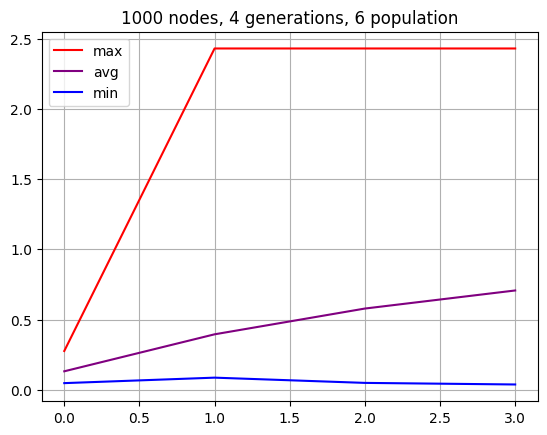

In [ ]:
pop_size = 6 # may increase as desired
genCount =  50# start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 5% chance of mutation
epsilon = 0.1
epsilon_lim = 3


fittest, all_scores = genetic_algorithm(genCount, test1000, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, test1000, startNode,endNode, pop_size)
GA_results_plot(results)

### 200-Node test network

This network generates 50% live nodes an 50% "dead" nodes (1e-8 health). This causes the network to have fewer edges in it, which decreases the compuation time required to identify all edges between nodes. This is a computational limit on the system.

In [ ]:
random.seed(13)

test500 = deepcopy(network)
networkSize = 200
p_health1k = 0.5 # forces chance for health of satellite to be non-zero to be low; useful for managing constellation edges and increasing computation speed.

nodes_500 = [str(i) for i in range(networkSize)]
offsets_500 = [rand()*2*math.pi for i in range(networkSize)]
health_500 =  [rand() if rand()< p_health1k else 1e-8 for i in range(networkSize)]

test500["nodes"] = nodes_500
test500["offsets"] = offsets_500
test500["node_health"] = health_500


In [ ]:
t1 = time.time()
test500 = update_network(test500, 2, 0.25)
t2 = time.time()

print("Elapsed time is",t2-t1)

Elapsed time is 0.29548120498657227


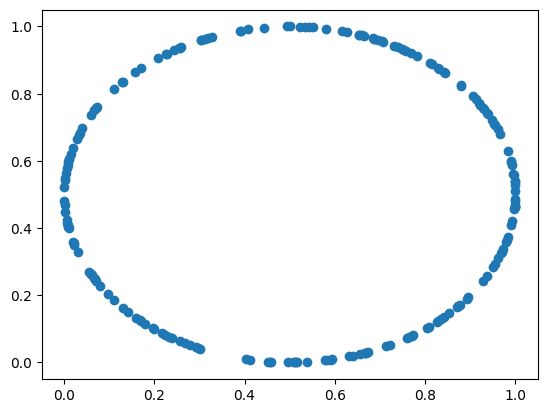

In [ ]:
plt.scatter(*zip(*test500["coordinates"]))

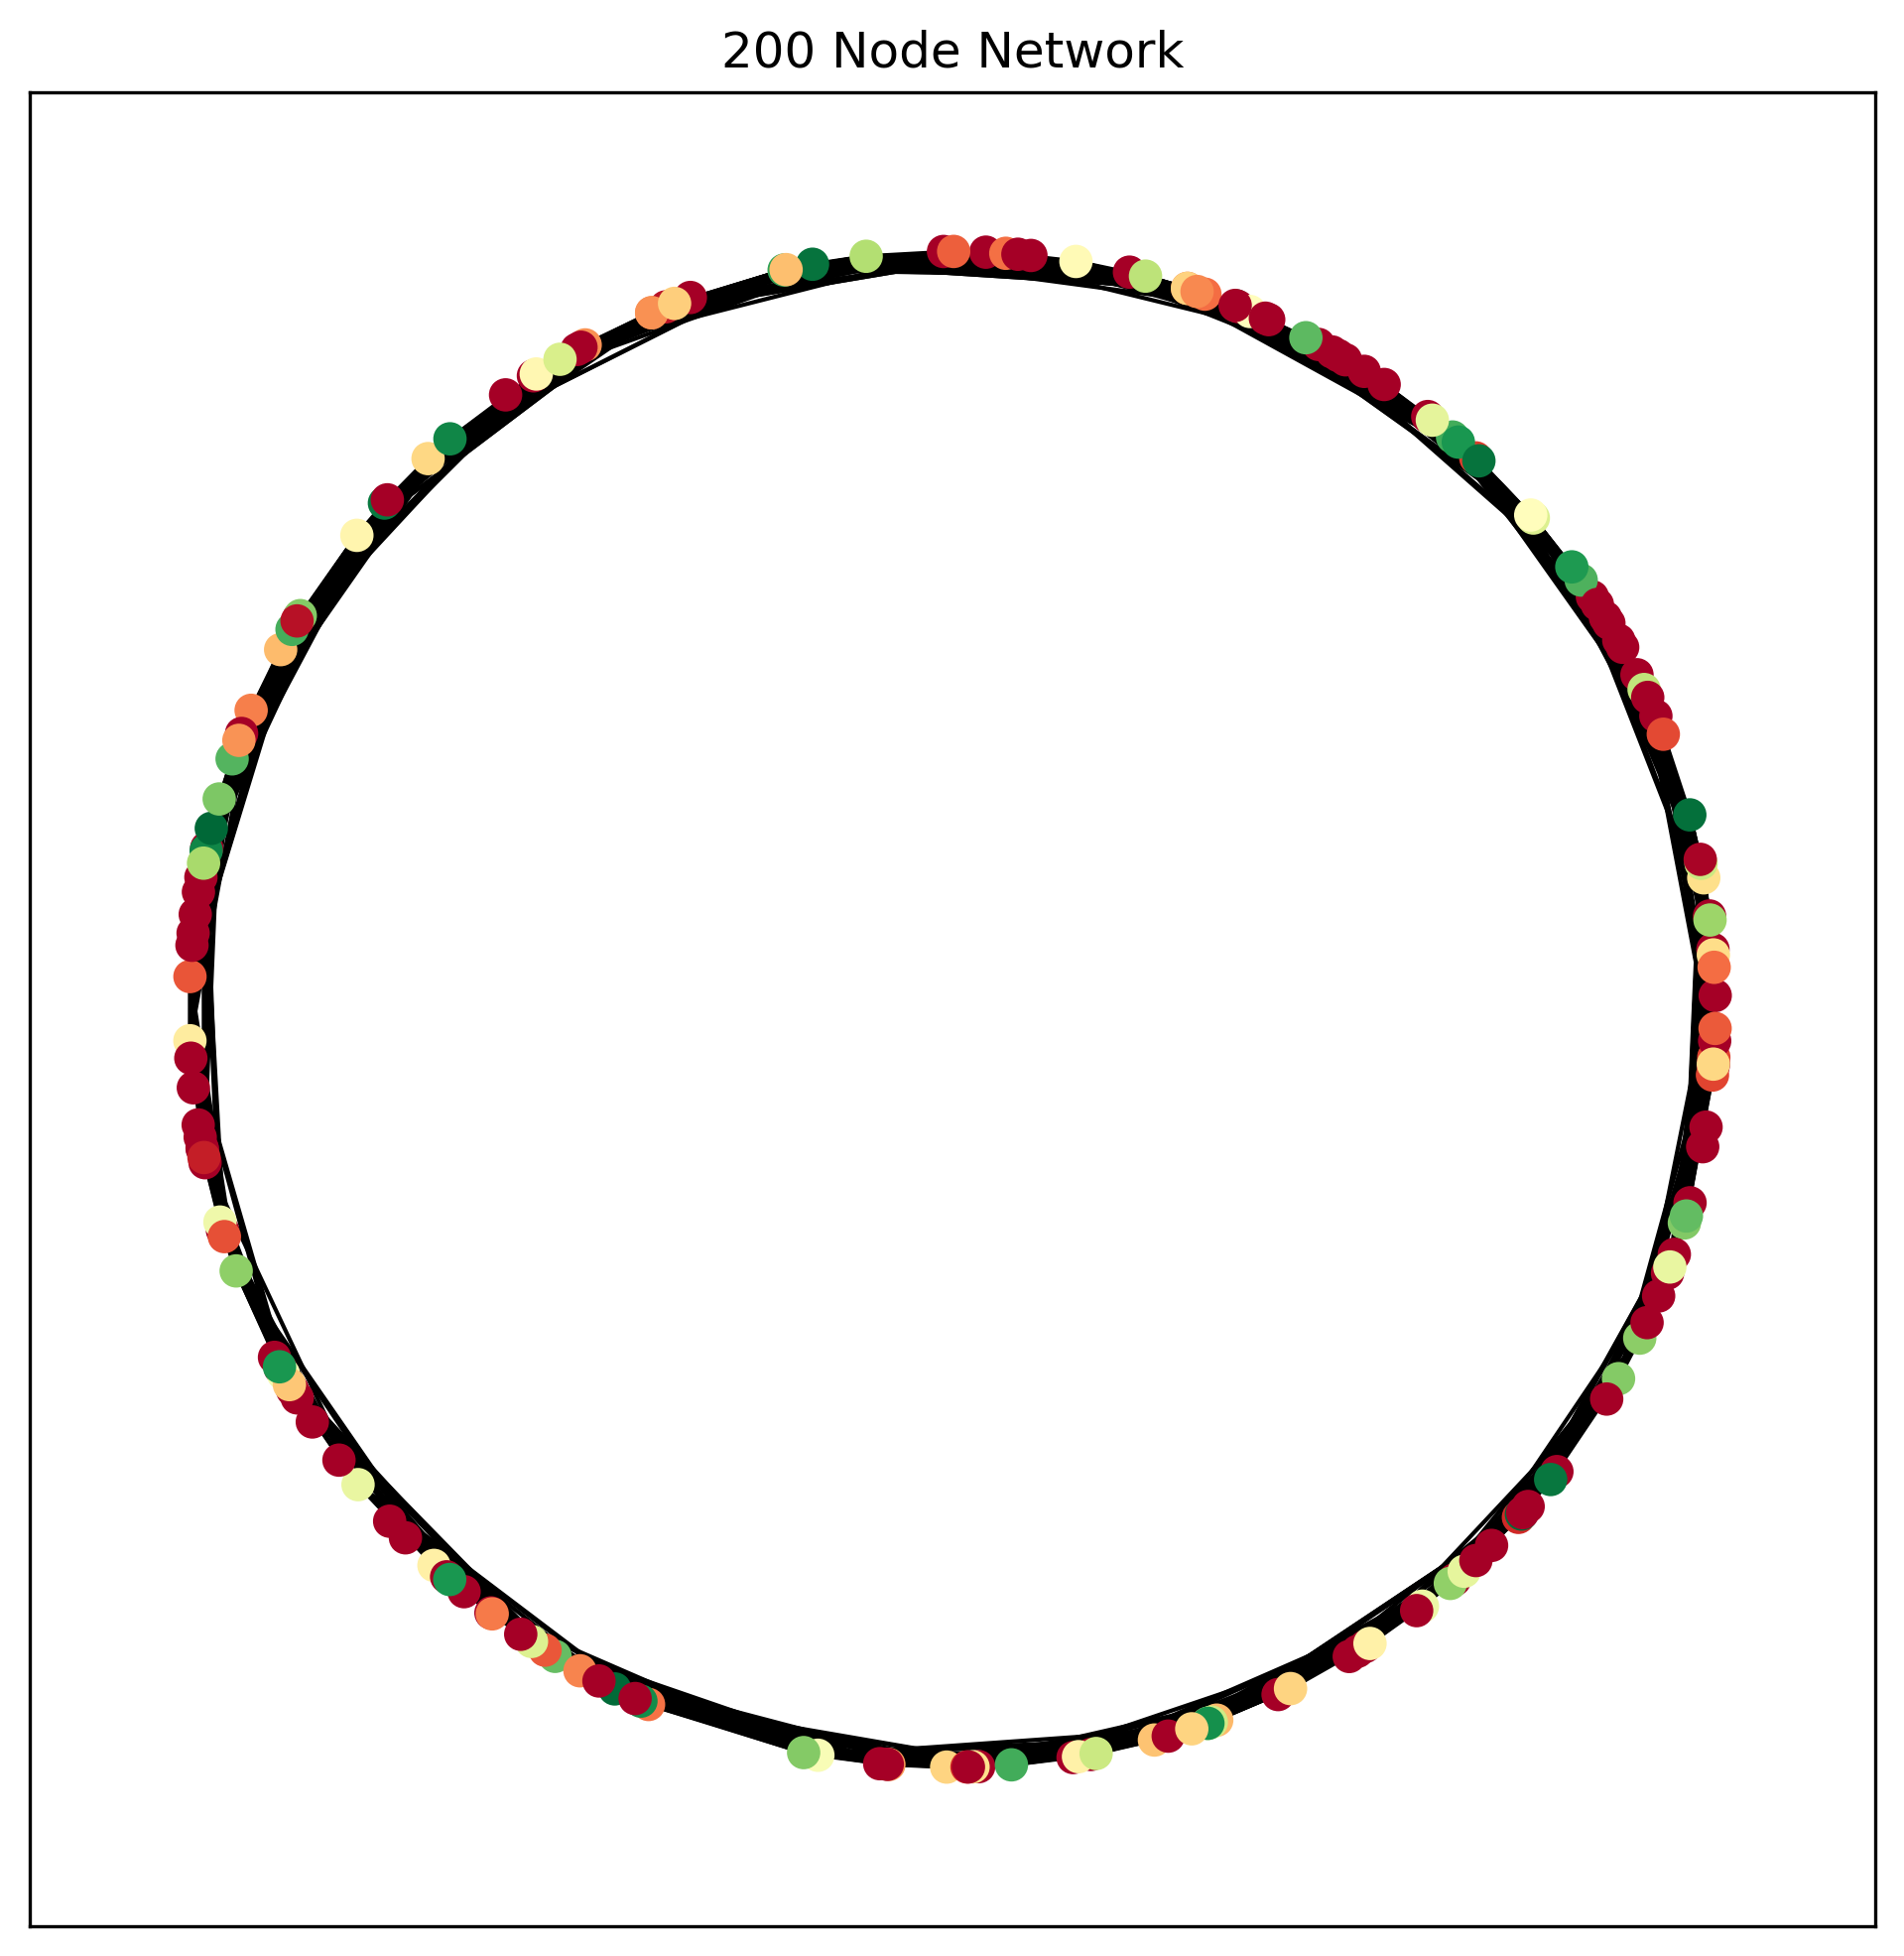

In [ ]:
draw_map("200 Node Network", test500, (8,8), False, True)

In [ ]:
pop_size = 400 # may increase as desired
genCount = 1000 # start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5

startNode = random.choice([a for a in test500["nodes"] if test500["node_health"][test500["nodes"].index(a)]>1e-6])
endNode = random.choice([a for a in test500["nodes"] if test500["node_health"][test500["nodes"].index(a)]>1e-6 and a != startNode])

print(startNode,"--> start node")
print(endNode,"--> end node")

ACO500_Start = startNode
ACO500_End = endNode


82 --> start node
88 --> end node


best score is ([138, 114, 133, 108, 91, 59, 64, 13, 104, 149, 196, 25, 85, 175, 90, 84, 20, 23, 121, 190, 171, 130, 43, 57, 176, 38, 82, 48, 174, 159, 28, 156, 173, 67, 167, 21, 93, 129, 170, 172, 37, 32, 99, 2, 153, 135, 125, 105, 179, 116, 74, 5, 163, 54, 187, 46, 178, 27, 89, 19, 18, 53, 123, 17, 96, 44, 94, 29, 144, 98, 112, 162, 177, 145, 192, 169, 0, 22, 95, 184, 148, 180, 181, 83, 60, 199, 41, 35, 191, 49, 165, 92, 122, 47, 136, 168, 152, 12, 188, 195, 72, 115, 8, 185, 50, 118, 75, 81, 97, 150, 154, 71, 61, 58, 69, 68, 186, 103, 40, 119, 39, 45, 120, 117, 78, 51, 134, 77, 194, 160, 73, 110, 147, 131, 9, 107, 42, 70, 88, 182, 127, 161, 55, 113, 34, 146, 126, 198, 79, 157, 63, 11, 52, 139, 14, 109, 183, 10, 106, 143, 26, 76, 62, 1, 66, 193, 166, 155, 142, 197, 56, 189, 100, 124, 65, 24, 80, 141, 31, 33, 132, 7, 140, 36, 30, 111, 102, 164, 86, 128, 15, 151, 3, 87, 158, 16, 101, 137, 4, 6], 8.732539842303302)
fittest individual is [138, 114, 133, 108, 91, 59, 64, 13, 104, 149, 196, 

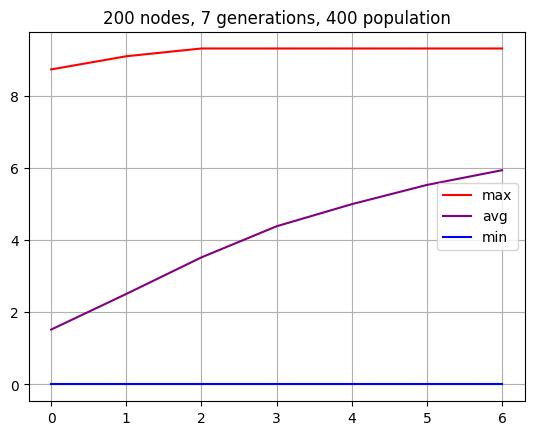

In [ ]:
fittest, all_scores = genetic_algorithm(genCount, test500, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)
results = print_results(fittest, all_scores, test500, startNode,endNode, pop_size)
GA_results_plot(results)

### 100-Node test network

This network has 100 nodes, all of which have randomly assigned values using the `rand()` function, ranging from 0 to 1.

In [ ]:
random.seed(14)

test100 = deepcopy(network)
networkSize = 100
#p_health100 = 0.25


nodes_100 = [str(i) for i in range(networkSize)]
offsets_100 = [rand()*2*math.pi for i in range(networkSize)]

# health_100 = [1 if rand()< p_health100 else 0 for i in range(networkSize)]
health_100 = [rand() for _ in range(networkSize)]

test100["nodes"] = nodes_100
test100["offsets"] = offsets_100
test100["node_health"] = health_100


In [ ]:
t1 = time.time()
test100 = update_network(test100, 3, 0.5)
t2 = time.time()

print("Elapsed time is",t2-t1)

Elapsed time is 0.41850709915161133


Generating a 100-node network is quite a bit faster than the 1000-node network: here, execution completes in less than 1 second (~0.4s is typical). All nodes are valid and have `node_health` values ranging from 0 to 1.

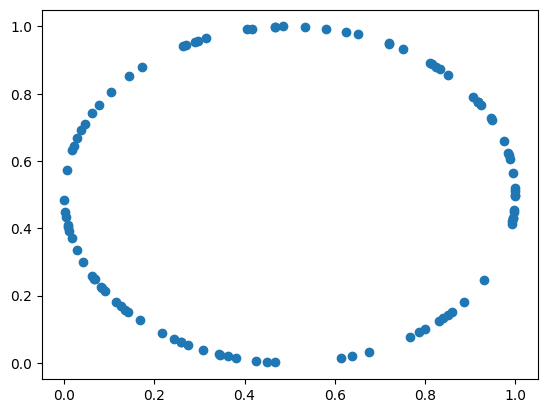

In [ ]:
plt.scatter(*zip(*test100["coordinates"]))

Compared with the 1000-node network, the 100-node network is much less densely packed - this hews more closely to the reality of existing satellite mega-constellations than than loading a single orbital plane with ~1000 satellites. While the orbital-plane complexity is more realistic, the overall complexity compared to a real constellation in 3D is less realistic in this case. The 1000-node network above, while a poor simulation of a single orbital plane, captures more of the realistic complexity of a very large network.

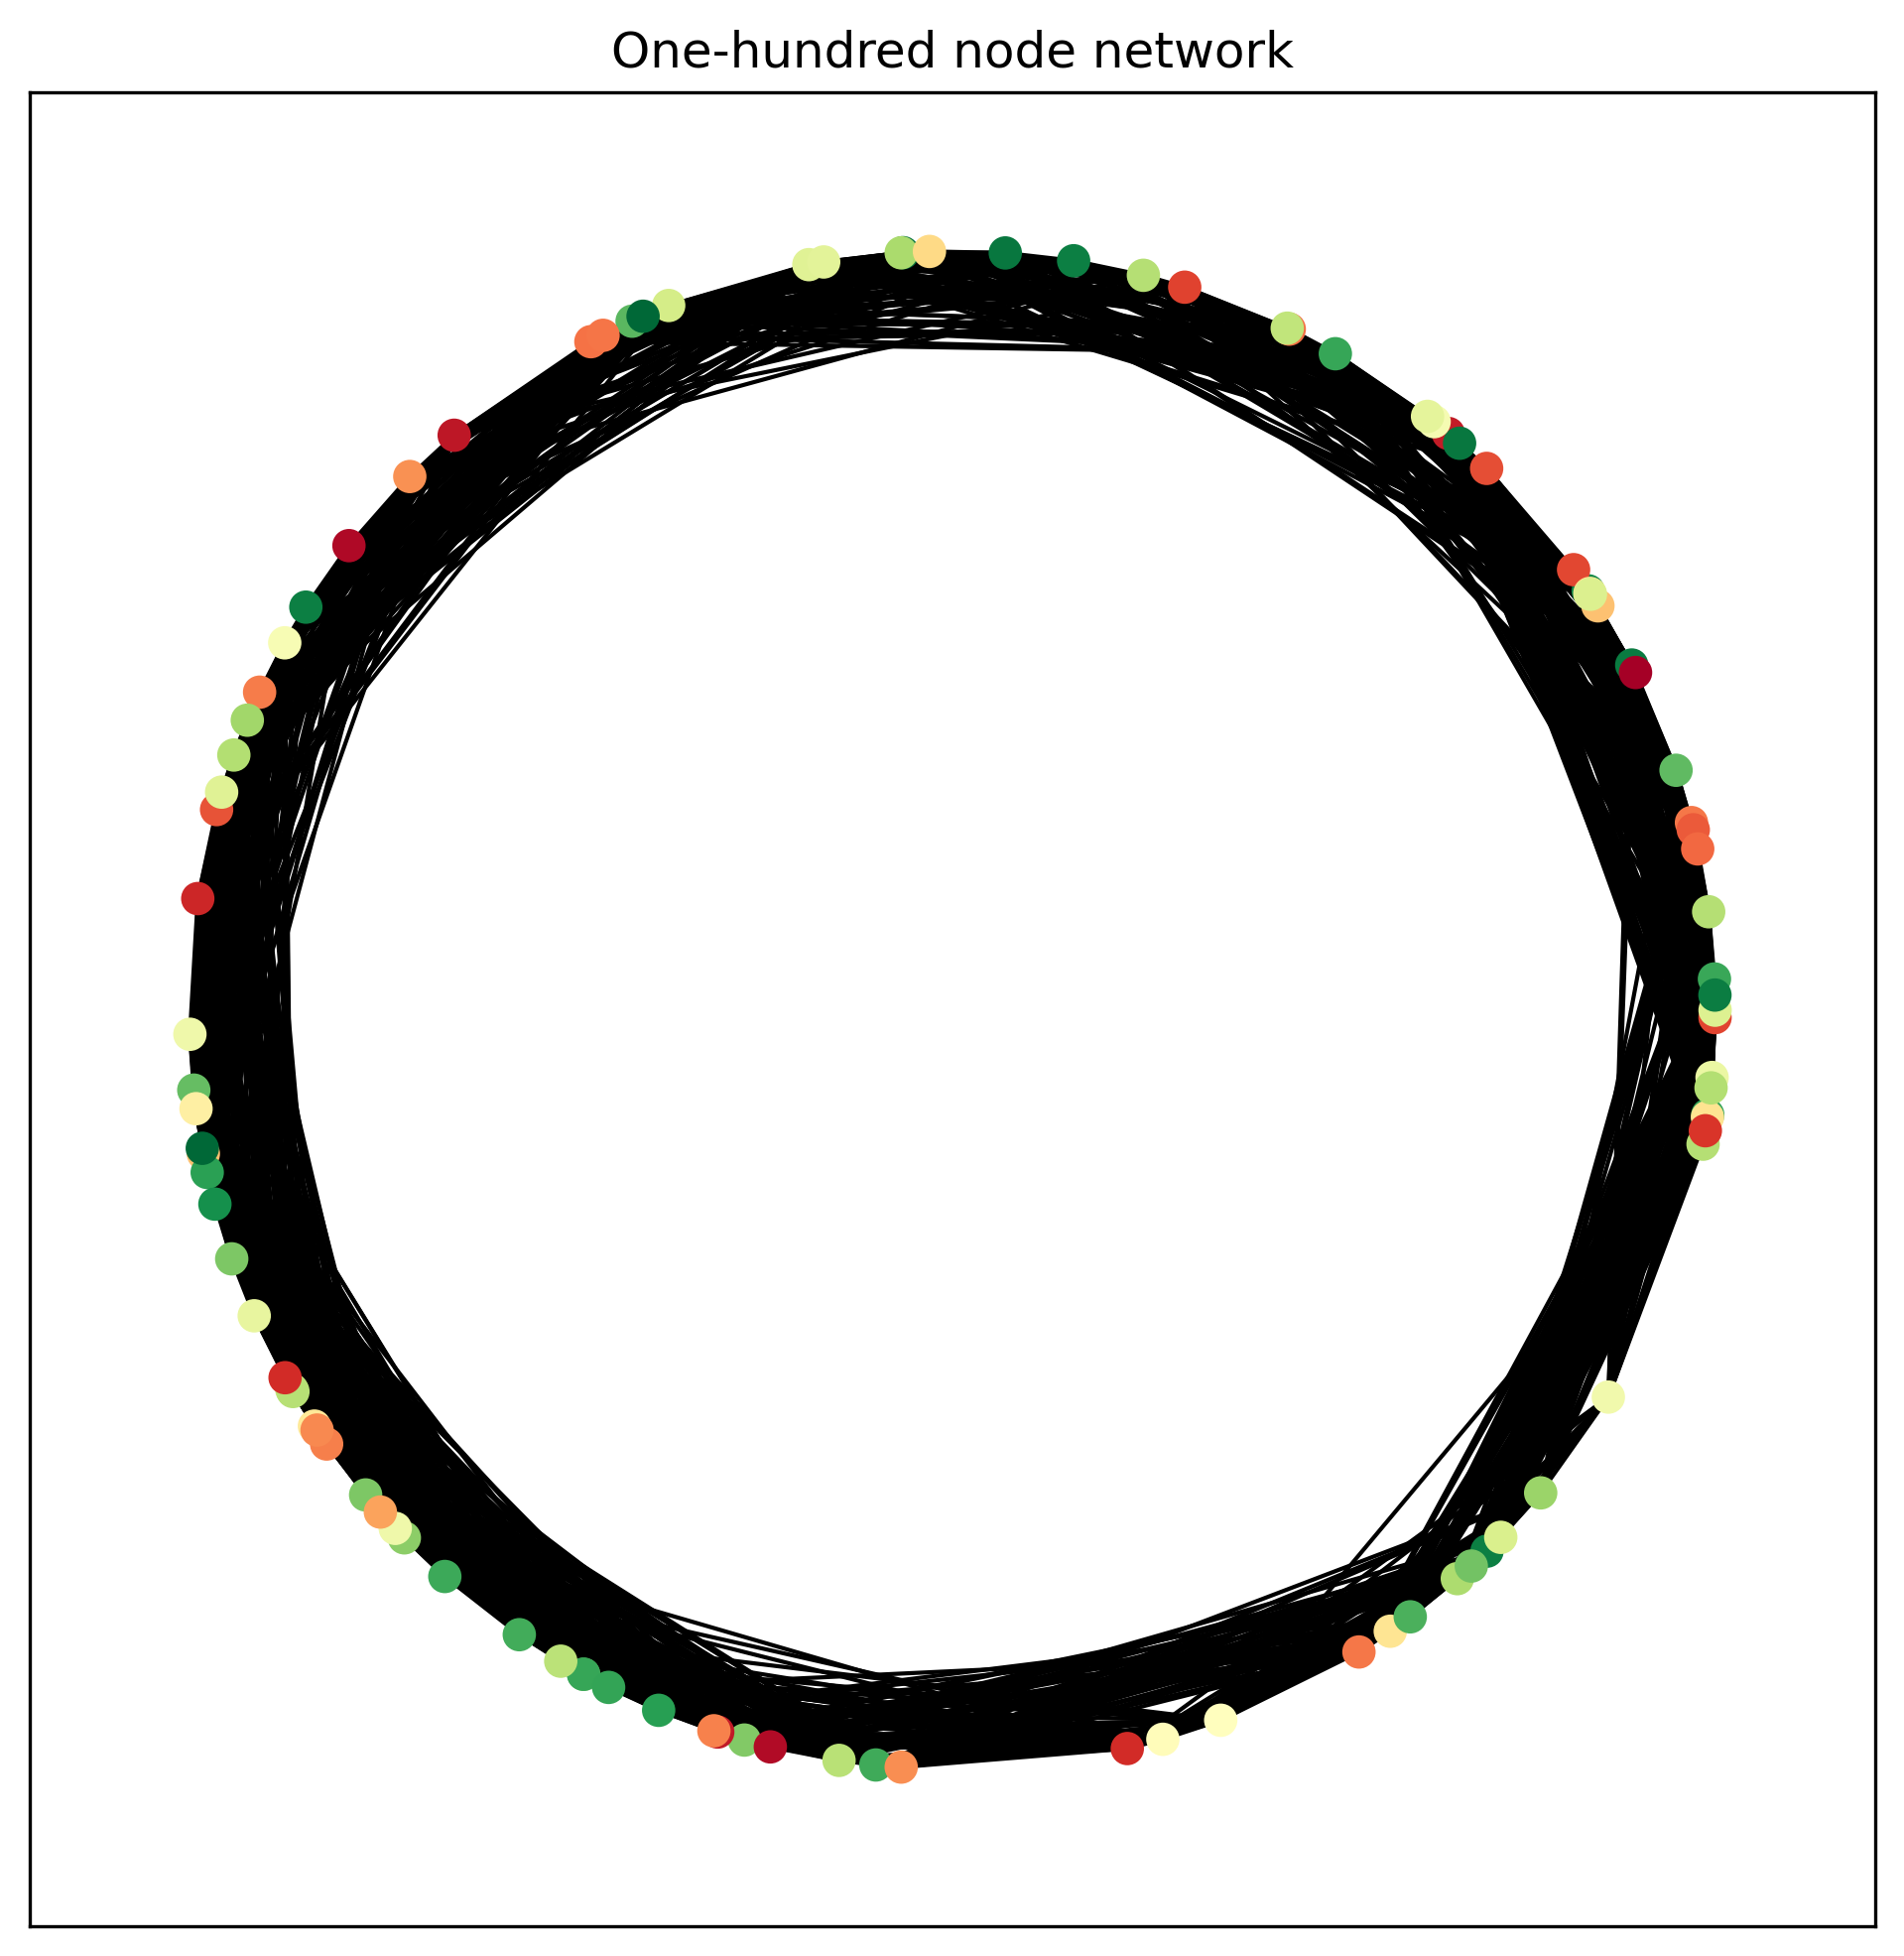

In [ ]:
draw_map("One-hundred node network", test100, (8,8), False, True)

In [ ]:
pop_size = 50 # may increase as desired
genCount = 1000 # start with 1000 generations
p_cross = 0.8 # 80% chance of crossover
p_mut = 0.05 # 10% chance of mutation
epsilon = 0.1
epsilon_lim = 5
startNode = random.choice([a for a in test100["nodes"] if test100["node_health"][test100["nodes"].index(a)]>1e-6])
endNode = random.choice([a for a in test100["nodes"] if test100["node_health"][test100["nodes"].index(a)]>1e-6 and a != startNode])

txRate = 100 # MB/s maximum data throughput out of a node
msgSize = 100 # MB, size of the message to send
nodeRate = 100 # MB/s through a node (and/or into a node?)

#Store start & end for use in ACO below
ACO100_Start = startNode
ACO100_End = endNode

best score is ([32, 14, 29, 97, 1, 25, 86, 84, 39, 4, 35, 71, 30, 28, 42, 17, 96, 6, 89, 23, 0, 70, 53, 64, 81, 62, 57, 87, 82, 63, 19, 58, 26, 33, 94, 76, 91, 59, 7, 31, 40, 65, 95, 72, 34, 20, 27, 54, 18, 55, 52, 50, 90, 41, 79, 21, 47, 15, 10, 12, 93, 16, 78, 60, 24, 75, 45, 68, 85, 77, 22, 2, 9, 37, 38, 69, 51, 88, 44, 99, 36, 13, 98, 46, 11, 83, 80, 56, 61, 43, 92, 49, 5, 73, 66, 74, 67, 48, 8, 3], 5.864941691316967)
fittest individual is [32, 14, 29, 97, 1, 25, 86, 84, 39, 4, 35, 71, 30, 28, 42, 17, 96, 6, 89, 23, 0, 70, 53, 64, 81, 62, 57, 87, 82, 63, 19, 58, 26, 33, 94, 76, 91, 59, 7, 31, 40, 65, 95, 72, 34, 20, 27, 54, 18, 55, 52, 50, 90, 41, 79, 21, 47, 15, 10, 12, 93, 16, 78, 60, 24, 75, 45, 68, 85, 77, 22, 2, 9, 37, 38, 69, 51, 88, 44, 99, 36, 13, 98, 46, 11, 83, 80, 56, 61, 43, 92, 49, 5, 73, 66, 74, 67, 48, 8, 3] with a score of 5.864941691316967 in generation 0
best score is ([18, 52, 92, 72, 22, 2, 85, 32, 82, 11, 63, 71, 5, 41, 54, 7, 17, 44, 47, 69, 23, 12, 73, 40, 46

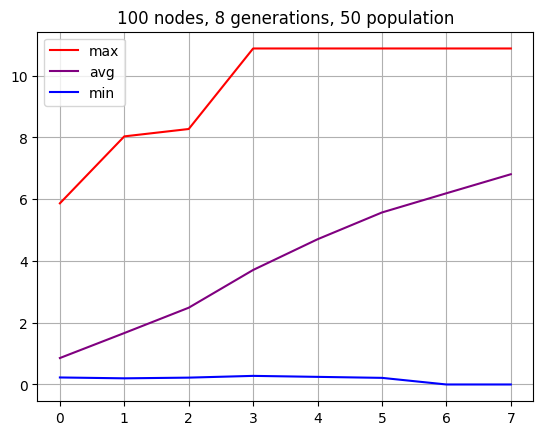

In [ ]:
# print(len(test100["nodes"]))
fittest, all_scores = genetic_algorithm(genCount, test100, pop_size, p_mut, p_cross, startNode, endNode, epsilon_lim, epsilon, txRate, msgSize, nodeRate)

results = print_results(fittest, all_scores, test100, startNode,endNode, pop_size)
GA_results_plot(results)

In [ ]:
test100_neighborhood = get_neighbors(test100["nodes"], test100["edges"])
#print(startNode, endNode)
#print(test100["nodes"])
#print(fittest)
path = create_path(startNode, endNode, test100["nodes"], fittest[0], test100_neighborhood)

print(path)
#(13,79) in test100['edges']

['13', '93', '79']


------
# Ant Colony Optimization
*ACO Code by John Ware: 8/22/23*



## Initial Test Network
*8-Node network used to set up ACO method & run initial tests*

In [ ]:
#initial test case
network = {"nodes": ["001", "002", "003", "004", "005", "006", "007", "008"],
           "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7),(7,0)], # defines which nodes are connected
           "coordinates": [(1.98,1.2),(.77,1.97),(.41,1.81),(.06,.65),(.6, .08),(1.28,.04),(1.83, .45),(1.93, .63)], # defines static location of nodes
           "offsets": [0.2, 1.8, 2.2, 3.5, 4.3, 5.0, 5.7, 5.9], # node offsets, which determines coordinates
           "node_health": [1, 1, 1, 1, 1, 1, 1, 1]} #arbitrarily assign 100% health to everything to start

nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

## Define Edge
Custom edge class used to store starting/ending nodes, weight of the edge, and current level of pheromone.

In [ ]:
# class ACO(ACO): #build on class
class Edge:
    def __init__(self, a, b, weight, initial_pheromone=1.0):
        self.a = a #starting node
        self.b = b #ending node
        self.weight = weight #same as cost
        self.pheromone = initial_pheromone #initiated to 1.0

## Define Node
Custom node class used to store basic node info, a list of edges, and helper functions to add neighbors using the custom *Edge* class.

In [ ]:
# class ACO(ACO): #build on class
class Node:
    def __init__(self, name, h, c):
        #The name of the node (can be anything, just for human readable output)
        self.name = name
        self.health = h #node health
        self.coord = c #node coordinates

        #Initiate the list of edges which connect the node
        self.edges = []

        # #The previous node in path to the goal
        # self.previous = None

    def add_neighbor(self, node, cost):
        new_edge = Edge(self, node, cost)#, initial_pheromone)
        self.edges.append(new_edge)

    def add_neighbor_bidirectional(self, node, cost):
        self.add_neighbor(node, cost)
        node.add_neighbor(self, cost)

## Fitness (Eta) Function

Helper function to calculate the value of eta - fitness / score of nearest neighbors. This feeds into roulette wheel selection of each subsequent node.

*This is the same logic as the GA Datarate function, adjusted for the ACO application*

In [ ]:
#Calculates value of eta (measure of goodness) between two nodes a & b
def get_eta(node1, node2):
  #constants:
  txRate = 100 #Mb/s
  msgSize = 100 #Mb
  nodeRate = 100 #Mb/s
  #orbit_alt =
  semimajor_axis = 7000 #6371 km Earth rad + 629 orb alt
  c = 299792 #lightspeed, km/s

  #initialize
  node_time_delay, path_latency, node_latency = 0.0, 0.0, 0.0
  q1, q2 = node1.health, node2.health #approx

  #Euclidean distance
  euc = math.dist(node1.coord, node2.coord)# * semimajor_axis

  #check if div by 0
  if euc == 0.0:
    euc = 0.0001

  #fixed delay caused by each node (hardware delay)
  node_time_delay = 2*msgSize/nodeRate #2 nodes * size / rate [s]

  #light delay (between nodes)
#   path_latency = euc / c
  path_latency = euc / c * semimajor_axis


  #node degradation delay
  node_latency = (msgSize/txRate * (1/q1)) + (msgSize/txRate * (1/q2))

  #path data rate
#   eta = msgSize/(1+(node_latency + path_latency + node_time_delay))
  eta = msgSize/(node_latency + path_latency + node_time_delay)

#   eta = 1/euc * q1 * q2
  #eta = 1/(euc**2) #1/r^2 approximation for link budget #can use to incorp min rate
  return eta

### Path Eta
Helper function to calculate eta across a path. This is the same logic as the node to node Eta calculation above, but is adjusted to not double-count node health decrements when stepping through a path.

In [ ]:
#Calculates value of eta (measure of goodness) along a path
def get_eta_path(path):
  #constants:
  txRate = 100 #Mb/s
  msgSize = 100 #Mb
  nodeRate = 100 #Mb/s
  #orbit_alt =
  semimajor_axis = 7000 #6371 km Earth rad + 629 orb alt
  c = 299792 #lightspeed, km/s

  #initialize
  node_time_delay, path_latency, node_latency = 0.0, 0.0, 0.0

  #Euclidean path distance
  path_dist = 0.0
  for i in (range(len(path) - 1)):
    path_dist += (math.dist(path[i].coord, path[i+1].coord))

  #fixed delay caused by each node (hardware delay)
  node_time_delay = len(path)*msgSize/nodeRate # num nodes * size / rate [s]

  #light delay (between nodes)
  path_latency = path_dist / c * semimajor_axis

  #node degradation delay
  for node in path:
    node_latency += (msgSize/txRate * (1/node.health))

  #path data rate
  eta_path = msgSize/(node_latency + path_latency + node_time_delay)

  return eta_path

## Initialize Nodes & Edges
Helper function to initialize custom nodes & edges from the dictionary.
- Generates Nodes
- Iterates through edges, adds each edge to its appropriate node
- Stores a list of all edges in custom class form

In [ ]:
def node_edge_init(network):
    ### --- Initialize Nodes --- ###
        #takes in nodes from dictionary, initializes as custom class
    cur_nodes = []
    for i in range(0, len(nodes)):
        #add custom node, form: Node(name, heatlh, coord)
        cur_nodes.append(Node(nodes[i], nodeHealth[i], coord[i]))


    ### --- Initialize Edges --- ###
        #takes in nodes and edges from dictionary, translates into custom classes for node & edge
        #cost (edge weight) is calculated using eta value
    for edge in edges:
        i, j = edge[0], edge[1] #decompose
        node1, node2 = cur_nodes[i], cur_nodes[j]
        cur_nodes[i].add_neighbor_bidirectional(cur_nodes[j], get_eta(node1, node2))

    #Store all edges in one list
    cur_edges = []
    for node in cur_nodes:
        for edge in node.edges:
            cur_edges.append(edge)

    #returns
    return cur_nodes, cur_edges

## Ants

Roulette wheel referencing https://www.educative.io/answers/what-is-roulette-wheel-selection

### Ant init
Initialize ant class with scaling parameters, and basic path information.

In [ ]:
class Ant():
    def __init__(self, alpha, beta, num_nodes, start, end): #removed edges
        self.alpha = alpha
        self.beta = beta
        self.num_nodes = num_nodes
        # self.edges = edges
        # self.tour = None
        self.tour = []
        self.distance = 0.0
        self.start = start #starting node
        self.end = end #ending node
        self.finished = False
        self.cur_node = start
        self.previous = start #init
        # self.running_eta = 0.0
        self.total_eta = 0.0

### _get_neighbors
Returns a list of nodes attached to the current node (self.cur_node)

In [ ]:
class Ant(Ant): #build
    def _get_neighbors(self):
        neighbors = []
        for edge in self.cur_node.edges:
            neighbors.append(edge.b)
        return neighbors

### _roulette_select
Probabilistic selection of the next node, based on roulette wheel formula.

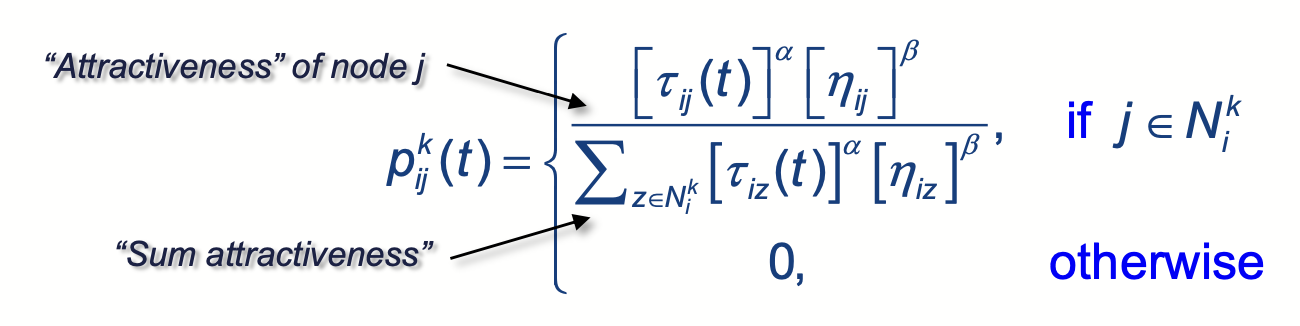

In [ ]:
class Ant(Ant): #build
    def _roulette_select(self): #roulette wheel to select next node
        roulette_wheel = 0.0
        heuristic_total = 0.0
        metrics = []
        probabilities = []

        # self.edges = self._get_edges()
        new_edges = []
        # for edge in self.edges:
        # print(self.cur_node, ' and Name is: ', self.cur_node.name)
        for edge in self.cur_node.edges:
            if edge.b not in self.tour:
                new_edges.append(edge)

        for new_edge in new_edges:
            val = pow(get_eta(self.cur_node, new_edge.b), self.beta) * pow(new_edge.pheromone, self.alpha) #individual metric (p^a * n^b)
            heuristic_total += val #denominator
            metrics.append(val)

        probabilities = []
        for num in metrics:
            probabilities.append(num / heuristic_total)

        randomNumber = round(uniform(0, 1),3) #where on wheel
        choose = 0
        count = 0
        for value in probabilities:
            choose = choose + value #cumulative
            # count +=1
            if choose >= randomNumber: #return this value (node)
                index = probabilities.index(value)
                return new_edges[index].b #next node

### _find_tour
Driver code to find a tour for each individual ant.
- Houses starting conditions, max iterations, stop conditions, and core *while* loop.
- Carries basic error handling for checking Node properties, max iterations, and a finished tour.

In [ ]:
class Ant(Ant): #build
    def _find_tour(self):
        if self.cur_node == self.start and self.tour == []:
            self.tour.append(self.start)

        iter = 0 #init
        max_iter = 100 #when to stop iterations

        while not self.finished and iter < max_iter:
          self.previous = self.cur_node #store current as previous
          self.cur_node = self._roulette_select() #reset to next node

          if self.cur_node is None:
            self.cur_node = self.previous
            # print('Error - next node is None, resetting to previous')
            iter+=1
            pass

          else:
            self.tour.append(self.cur_node) #add to tour
            # self.distance +=

          if self.cur_node == self.end:
            self.finished = True
            # print('Finished tour!')

        #   if iter == (max_iter - 1):
            # print('Error: max iterations reached!')
          iter += 1 #increment

        return self.tour

### _get_distance
Returns total euclidean (unit) distance of a tour. To conver this to an actual distance, multiply by the semimajor axis (7000 km in this simulation)

In [ ]:
class Ant(Ant):
    def _get_distance(self):
        #Returns total distance of tour
        self.distance = 0.0 #reset each time called
        for i in range(len(self.tour) - 1):
            euc = math.dist(self.tour[i].coord, self.tour[i+1].coord)
            self.distance += euc

        return self.distance

### _get_tour_edges
Outputs list of all edges (in custom class form) within the current tour.

In [ ]:
class Ant(Ant): #build
    def _get_tour_edges(self):
        tour_edges = []
        for i in range(len(self.tour) - 1):
            for edge in self.tour[i].edges:
                if edge.b == self.tour[i+1]:
                    tour_edges.append(edge)
        return tour_edges


### _get_total_eta
Calculates total fitness function across finished tour. Points back to the Path Eta function.

In [ ]:
class Ant(Ant): #build
    def _get_total_eta(self, msgsize=100, datarate_mbps=100):
        self.total_eta = get_eta_path(self.tour)

## ACO Method

### ACO init
Primary class initialization for ACO; stores information about scaling factors and coefficients, 'global' variables for best path information, and initializes the ant colony.

In [ ]:
class ACO():
    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, edges=None, labels=None,
                start_node_index=None, end_node_index=None):
        #initialize
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight #can likely remove
        self.min_scaling_factor = min_scaling_factor #potential remove
        self.rho = rho #pheromone evaporation coefficient
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        self.cur_edges = edges
        self.start = nodes[start_node_index] #starting node
        self.end = nodes[end_node_index] #ending node

        # self.pathfound = False
        self.semimajor_axis = 7000 #km

        #define labels
        if labels is not None:
            self.labels = labels
        else: #define labels as node names
            self.labels = []
            for node in nodes:
                self.labels.append(node.name)

        #Create ants & tour
        self.ants = [Ant(alpha, beta, self.num_nodes, self.start,
                            self.end) for _ in range(self.colony_size)] #removed self.edges

        #init globals
        self.global_best_tour = None
        self.global_best_distance = float("inf")
        self.global_best_eta = 0.0

### _add_pheromone
Function to lay pheromone along edges after a successful tour.
- Handles a 'divide by 0' error
- Divides total pheromone across total distance traveled
- Lays pheromone proportional to distance on each individual edge

In [ ]:
class ACO(ACO):
    def _add_pheromone(self, tour, distance, tour_edges, weight=1.0): #change edges
        if distance == 0.0:
            distance = 1.0

        pheromone_to_add = self.pheromone_deposit_weight / distance

        for edge in tour_edges:
            edge.pheromone += weight * pheromone_to_add

### _send_ants
Driver function to initialize and deploy ant colony
- Steps through each time step in epoch
- Calculates individual ant tour
- Lays pheromone
- Checks against global best tour, stores if appropriate
- Evaporates pheromone with each time step, based on rho evaporation coefficient

In [ ]:
class ACO(ACO):
    def _send_ants(self): #primary running function
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant._find_tour(), ant._get_distance(), ant._get_tour_edges())
                # if ant.distance < self.global_best_distance:
                #     self.global_best_tour = ant.tour
                #     self.global_best_distance = ant.distance
                ant._get_total_eta()
                if ant.total_eta > self.global_best_eta: #fittest tour
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
                    self.global_best_eta = ant.total_eta
            #Evaporation
            for edge in self.cur_edges: #all edges
                edge.pheromone *= (1.0 - self.rho) #evaporate on all

### run
Main driver / run function for Ant Colony Optimization
- Calls _send_ants function
- Houses print statements for results

In [ ]:
class ACO(ACO):
    def run(self):
        if self.mode == 'ACS':
            self._send_ants()
        #insert other methods / modes if needed

        #Print Statements
        print('Size of Simulation: ', len(nodes))
        print('Start, End nodes: ', self.start.name, ',', self.end.name)
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.global_best_tour[i].name) for i in range(len(self.global_best_tour)))))
        print('Total unit distance traveled to complete the tour : {0}'.format(round(self.global_best_distance, 2)))
        print('Total km distance traveled: {0}'.format(round(self.global_best_distance*self.semimajor_axis, 2)))
        print('Total number of nodes in path : ', len(self.global_best_tour))
        print('Total Effective Data rate (Eta) [Mb/s] : ', get_eta_path(self.global_best_tour))

## ACO Main
- Includes information about colony size (number of ants), number of time steps to run, start & ending nodes.
- Initializes custom nodes and edges from the dictionary
- Calls the primary ACO function

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch
start_node_index = 6 #0-based
end_node_index = 2

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  8
Start, End nodes:  007 , 003
Sequence : <- 007 - 005 - 003 ->
Total unit distance traveled to complete the tour : 3.02
Total km distance traveled: 21173.93
Total number of nodes in path :  3
Total Effective Data rate (Eta) [Mb/s] :  16.472758284510522


## Test Cases

### Validation case 1: 8-node network

In [ ]:
# Copy 8 Node validation network from GA above
network = deepcopy(eight_node_val)
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch
start_node_index = 5 #0-based
end_node_index = 1

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  8
Start, End nodes:  006 , 002
Sequence : <- 006 - 004 - 003 - 002 ->
Total unit distance traveled to complete the tour : 1.15
Total km distance traveled: 8060.86
Total number of nodes in path :  4
Total Effective Data rate (Eta) [Mb/s] :  12.45812797731723


### Validation case 2: 100-node hand-picked scenario

In [ ]:
# Copy 100 Node network from GA above
network = deepcopy(hundred_node_val)
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch
start_node_index = 88 #0-based
end_node_index = 97

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  100
Start, End nodes:  88 , 97
Sequence : <- 88 - 26 - 39 - 64 - 97 ->
Total unit distance traveled to complete the tour : 1.19
Total km distance traveled: 8328.17
Total number of nodes in path :  5
Total Effective Data rate (Eta) [Mb/s] :  9.972297114174891


### 1000 Node Test Case

In [ ]:
# Copy 1000 Node network from GA above
network = deepcopy(test1000)
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch

#Pull starting / ending nodes from GA condition above (randomly generated) (0-based)
start_node_index = int(ACO1k_Start) #0-based
end_node_index = int(ACO1k_End)
# start_node_index = 295
# end_node_index = 349

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  1000
Start, End nodes:  293 , 337
Sequence : <- 293 - 362 - 358 - 179 - 919 - 666 - 60 - 126 - 352 - 320 - 244 - 475 - 337 ->
Total unit distance traveled to complete the tour : 1.54
Total km distance traveled: 10750.8
Total number of nodes in path :  13
Total Effective Data rate (Eta) [Mb/s] :  2.6738898151452


### 200 Node Test Case

In [ ]:
# Copy 1000 Node network from GA above
network = deepcopy(test500)
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch

#Pull starting / ending nodes from GA condition above (randomly generated) (0-based)
start_node_index = int(ACO500_Start)
end_node_index = int(ACO500_End)

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  200
Start, End nodes:  82 , 88
Sequence : <- 82 - 187 - 33 - 88 ->
Total unit distance traveled to complete the tour : 0.55
Total km distance traveled: 3857.72
Total number of nodes in path :  4
Total Effective Data rate (Eta) [Mb/s] :  9.313298608475884


### 100 Node Test Case

In [ ]:
# Copy 100 Node network from GA above
network = deepcopy(test100)
nodes = network["nodes"]
edges = network["edges"]
coord = network["coordinates"]
nodeHealth = network["node_health"]

In [ ]:
# Call Main function

# Inputs
_colony_size = len(nodes) #rule of thumb: size = num nodes (from network dict)
_steps = 50 #within each epoch

#Pull starting / ending nodes from GA condition above (randomly generated) (0-based)
start_node_index = int(ACO100_Start) #0-based
end_node_index = int(ACO100_End)

#Initialize custom Nodes & Edges from Dict
cur_nodes, cur_edges = node_edge_init(network)

#Function Call
acs = ACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=cur_nodes,
          edges=cur_edges, start_node_index=start_node_index, end_node_index=end_node_index)
acs.run()

Size of Simulation:  100
Start, End nodes:  13 , 79
Sequence : <- 13 - 47 - 46 - 8 - 79 ->
Total unit distance traveled to complete the tour : 1.66
Total km distance traveled: 11586.63
Total number of nodes in path :  5
Total Effective Data rate (Eta) [Mb/s] :  6.733466820101937
